In [1]:
import math
import os

import matplotlib.dates as mdates
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import MSTL, STL

from msig import Motif, NullModel

params = {"legend.fontsize": "xx-large", "axes.labelsize": 20}
pylab.rcParams.update(params)

In [2]:
# read csv
hourly_taz_data = pd.read_csv(
    "../data/populationdensity/hourly_taz.csv",
    parse_dates=["one_time"],
    date_format="%Y-%m-%d %H:%M:%S",
    index_col=0,
)
# taz_id to taz_name dict
taz_id_name = {}
for taz_id in hourly_taz_data["taz_id"].unique():
    taz_name = hourly_taz_data[hourly_taz_data["taz_id"] == taz_id]["taz_name"].values[
        0
    ]
    taz_id_name[taz_id] = taz_name

hourly_taz_data = hourly_taz_data[hourly_taz_data["taz_name"] != "Beato (Picheleira)"]
hourly_taz_data = hourly_taz_data[
    hourly_taz_data["taz_name"] != "Alcântara (Ribeirinha - Belém)"
]
hourly_taz_data

taz_id                                taz_name            one_time  \
0           69                     Areeiro (Alto Pina) 2021-11-26 09:00:00   
1           70                     Arroios (Estefânia) 2021-11-26 09:00:00   
2           71               Arroios (Arroios | Norte) 2021-11-26 09:00:00   
3           53                 Alvalade (Campo Grande) 2021-11-26 09:00:00   
4           40              Lumiar (Telheiras | Oeste) 2021-11-26 09:00:00   
...        ...                                     ...                 ...   
175218      16                       Estrela (Estrela) 2021-11-26 09:00:00   
175219      12                   Ajuda (Ajuda | Norte) 2021-11-26 09:00:00   
175220      15                          Estrela (Lapa) 2021-11-26 09:00:00   
175221      13            Estrela (Ribeirinha - Belém) 2021-11-26 09:00:00   
175222      66  Avenidas Novas (Avenidas Novas | Este) 2021-11-26 09:00:00   

        sum_terminals  sum_roaming_terminals  sum_terminals_with_active_data  \
0             61599.0                 1131.0                         58113.0   
1            145078.0                 4477.0                        138532.0   
2             31194.0                  945.0                         29608.0   
3             51055.0                  864.0                         48474.0   
4             40523.0                  255.0                         37014.0   
...               ...                    ...                             ...   
175218       199615.0                 6739.0                        190222.0   
175219        27901.0                  487.0                         25890.0   
175220         9932.0                  432.0                          9298.0   
175221         6586.0                  138.0                          6119.0   
175222       150273.0                 2975.0                        142580.0   

        sum_roaming_terminals_with_active_data  sum_phonecalls  \
0                                       1107.0          2896.0   
1                                       4351.0          5149.0   
2                                        920.0          1284.0   
3                                        849.0          1520.0   
4                                        252.0          2314.0   
...                                        ...             ...   
175218                                  6497.0          7990.0   
175219                                   481.0          1100.0   
175220                                   429.0           605.0   
175221                                   138.0           410.0   
175222                                  2910.0          6224.0   

        sum_ended_phonecalls  avg_upstream_bandwidth  \
0                      574.0             7524.772105   
1                     1178.0             7678.938176   
2                      420.0             5017.655536   
3                      474.0             8951.088582   
4                      382.0             3442.786203   
...                      ...                     ...   
175218                1839.0            10347.174511   
175219                 342.0           199281.838168   
175220                 154.0             3801.634144   
175221                  77.0             2781.907062   
175222                1741.0             9989.279638   

        avg_downstream_bandwidth  min_avg_downstream_bandwidth  \
0                  101178.976512                    104.328000   
1                   53412.218959                   2752.320035   
2                   58454.086946                    943.014966   
3                   70079.739010                   2236.359946   
4                   32570.243025                      1.238571   
...                          ...                           ...   
175218              75677.619332                    573.914546   
175219             236425.820611                      0.000000   
175220              39603.158490                  

In [3]:
results_path = "../results/populationdensity/hourly_taz"
# create folders in results path
if not os.path.exists(results_path):
    os.makedirs(results_path + "/mp")

In [4]:
features = ["sum_terminals"]
stats_table = pd.DataFrame()
resids = {}
# for each taz_id
for taz_id in hourly_taz_data["taz_id"].unique():
    # get the data for that taz_id
    taz_data = hourly_taz_data[hourly_taz_data["taz_id"] == taz_id]
    taz_data = taz_data.drop(columns=["taz_name"])
    taz_data["datetime"] = pd.to_datetime(taz_data["one_time"])
    taz_data = taz_data.drop(columns=["one_time", "taz_id", "wkt_taz"])
    taz_data.set_index("datetime", inplace=True)
    for data_feature in features:
        time_serie = taz_data[[data_feature]].asfreq("h")
        if np.all(time_serie == 0):
            continue
        res = MSTL(np.squeeze(time_serie), periods=[24, 24 * 7]).fit()
        resids[str(taz_id) + "_" + data_feature] = res.resid

        var_resid = np.var(res.resid)
        var_observed = np.var(res.observed)
        trend_strength = max(0, 1 - (var_resid / np.var(res.trend + res.resid)))
        noise_strength = var_resid / var_observed

        seasonal_individial_strengths = {}
        for period in res.seasonal:
            seasonal_individial_strengths["F_" + str(period)] = max(
                0, 1 - (var_resid / np.var(res.seasonal[period] + res.resid))
            )
        seasonal_strength = max(
            0, 1 - (var_resid / np.var(res.seasonal.sum(axis=1) + res.resid))
        )

        stats_df = {
            "id": taz_id,
            "Name": taz_id_name[taz_id],
            "Feature": data_feature,
            "F_T": round(trend_strength, 3),
            "F_S": round(seasonal_strength, 3),
            "F_R": round(noise_strength, 3),
        }

        # add individual seasonal strengths to stats_df, rounded with 3 decimals
        for period in seasonal_individial_strengths:
            stats_df[period] = round(seasonal_individial_strengths[period], 3)

        stats_table = pd.concat(
            [stats_table, pd.DataFrame(stats_df, index=[0])], ignore_index=True
        )

pd.DataFrame(resids).to_csv(results_path + "/resids.csv", index=True)
stats_table = stats_table.sort_values(by=["F_R"], ascending=False)
stats_table.to_csv(results_path + "/decomposition_summary.csv", index=False)
stats_table.head().to_latex()

'\\begin{tabular}{lrllrrrrr}\n\\toprule\n & id & Name & Feature & F_T & F_S & F_R & F_seasonal_24 & F_seasonal_168 \\\\\n\\midrule\n5 & 37 & São Domingos de Benfica (Estrada Luz | Oeste) & sum_terminals & 0.059000 & 0.404000 & 0.574000 & 0.267000 & 0.236000 \\\\\n7 & 41 & Lumiar (Telheiras | Este) & sum_terminals & 0.057000 & 0.554000 & 0.434000 & 0.414000 & 0.351000 \\\\\n64 & 77 & Penha de França (Penha França) & sum_terminals & 0.352000 & 0.445000 & 0.425000 & 0.319000 & 0.252000 \\\\\n57 & 72 & Arroios (Arroios | Sul) & sum_terminals & 0.293000 & 0.510000 & 0.406000 & 0.378000 & 0.305000 \\\\\n36 & 83 & Marvila (Chelas) & sum_terminals & 0.366000 & 0.470000 & 0.403000 & 0.328000 & 0.282000 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [5]:
# motif discovery
import stumpy
from stumpy import config

config.STUMPY_EXCL_ZONE_DENOM = 2  # r = np.ceil(m/2)
top_k_mp = 1
include = None
normalize = True
subsequence_lengths = [6, 12, 24]

resids = pd.read_csv(results_path + "/resids.csv", index_col=0)

# plot the data and residuals of top 3 taz_ids
top_taz_ids = stats_table["id"].head(3).values
# create dataframe with taz_id and resids
top_resids = pd.DataFrame()
for taz_id in top_taz_ids:
    for data_feature in features:
        # add to dataframe, id, data feature and daoly
        observed = (
            hourly_taz_data[hourly_taz_data["taz_id"] == taz_id][
                [data_feature, "one_time"]
            ]
            .sort_values(by="one_time")
            .set_index("one_time")
        )
        index = observed.index.values
        row = {
            "id": taz_id,
            "feature": data_feature,
            "index": index,
            "observed": observed.T.values[0],
            "residuals": resids[str(taz_id) + "_" + data_feature],
        }
        top_resids = pd.concat([top_resids, pd.DataFrame(row)], ignore_index=True)


## for (id, feature) get dataframe and plot observed and residuals
# for i, df in top_resids.groupby(by=["id", "feature"]):
#    # plot observed and residuals
#    fig, axes = plt.subplots(figsize=(5, 2), ncols=1, nrows=2, sharex=True)
#    observed = pd.DataFrame(df["observed"].values, index=df["index"])
#    resid = pd.DataFrame(df["residuals"].values, index=df["index"])
#    observed.plot(ax=axes[0], legend=False, label="", xlabel="", ylabel="Observed")
#    resid.plot(ax=axes[1], style=".", legend=False, xlabel="", ylabel="Residual")
#    axes[0].axes.get_xaxis().set_visible(False)
#    plt.show()

for m in subsequence_lengths:
    for i, df in top_resids.groupby(by=["id", "feature"]):
        X = np.squeeze(df["residuals"].values)
        out = stumpy.stump(X, m, normalize=normalize, k=top_k_mp)
        np.save(
            results_path
            + "/mp/hourly_taz_normalize={}_topkmp={}_m={}_{}_{}.npy".format(
                normalize, top_k_mp, m, i[0], i[1]
            ),
            out,
            allow_pickle=True,
        )

In [6]:
def multivar_subsequence_complexity(x):
    # complexity for multivariate time series can be calculated as the sum of the complexity of each dimension
    return np.sum(np.sqrt(np.sum(np.square(np.diff(x)), axis=1)))


def table_summary_motifs(
    motif_indices,
    motif_distances,
    motif_subspaces,
    data,
    k_distances,
    m,
    normalize,
    max_allowed_dist,
):
    mp_stats_table = pd.DataFrame(
        columns=[
            "ID",
            "k_distances",
            "Features",
            "m",
            "#Matches",
            "Indices",
            "max(dists)",
            "min(dists)",
            "med(dists)",
        ]
    )

    motif_index = 0

    n_vars, n_time = data.shape

    if normalize:
        data = (data - np.mean(data, axis=1)[:, np.newaxis]) / np.std(data, axis=1)[
            :, np.newaxis
        ]

    dtypes = [float] * len(data)
    model_empirical = NullModel(data, dtypes, model="empirical")

    for motif_indice, match_indices in enumerate(motif_indices):
        dimensions = motif_subspaces[motif_indice]

        # remove filling values of -1 and Nans from motif_indices and match_distances
        match_indices = match_indices[match_indices != -1]
        match_distances = motif_distances[motif_indice]
        match_distances = match_distances[~np.isnan(match_distances)]

        # if is empty, skip
        if len(match_indices) == 0:
            continue

        excl_zone = np.ceil(m / config.STUMPY_EXCL_ZONE_DENOM)

        # remove trivial matches
        non_trivial_matches = []
        for indice in match_indices:
            trivial = False
            for indice_new in non_trivial_matches:
                if abs(indice - indice_new) <= excl_zone:
                    trivial = True
                    break
            if not trivial:
                non_trivial_matches.append(indice)
        match_indices = non_trivial_matches

        max_possible_matches = int(np.floor((n_time - m) / excl_zone + 1))

        # get the multidim time serie motif in the dimensions
        multivar_subsequence = data[dimensions][
            :, match_indices[0] : match_indices[0] + m
        ]

        # minmax normalize subsequence
        epsilon = 1e-10  # to avoid division by zero
        min_values = multivar_subsequence.min(axis=1, keepdims=True)
        max_values = multivar_subsequence.max(axis=1, keepdims=True)
        normalized_multivar_subsequence = (multivar_subsequence - min_values) / (
            max_values - min_values + epsilon
        )
        ce_norm_subsequence = multivar_subsequence_complexity(
            normalized_multivar_subsequence
        )
        norm_ce_norm_subsequence = ce_norm_subsequence / (
            np.sqrt(len(multivar_subsequence[0]) - 1) * len(dimensions)
        )

        max_dist = np.max(match_distances)
        min_dist = np.min(match_distances[1:])

        if k_distances is None:  # consider all matches
            med_dist = np.median(match_distances[1:])
        else:  # consider only the k closest matches
            med_dist = np.median(match_distances[1 : k_distances + 1])

        # np.nanmax([np.nanmean(D) - 2.0 * np.nanstd(D), np.nanmin(D)])
        if max_allowed_dist is None:
            # D The distance profile of `Q` with `T`. It is a 1D numpy array of size
            # `len(T)-len(Q)+1`, where `D[i]` is the distance between query `Q` and
            # `T[i : i + len(Q)]`
            D = np.empty((n_vars, n_time - m + 1))
            for i in range(n_vars):
                D[i, :] = stumpy.mass(
                    multivar_subsequence[i], data[i], normalize=normalize
                )
            D = np.mean(D, axis=0)
            D_copy = D.copy().astype(np.float64)
            D_copy[np.isinf(D_copy)] = np.nan
            motif_max_allowed_dist = np.nanmax(
                [np.nanmean(D_copy) - 2.0 * np.nanstd(D_copy), np.nanmin(D_copy)]
            )
        else:
            motif_max_allowed_dist = max_allowed_dist

        unified_weights = "0.33,0.33,0.33"
        w1, w2, w3 = map(float, unified_weights.split(","))
        unified = (
            w1 * (1 - (med_dist / motif_max_allowed_dist))
            + w2 * (len(match_indices) / max_possible_matches)
            + w3 * norm_ce_norm_subsequence
        )

        # remove timepoints from time series in match all indices + m
        time_series_nomatches = data.copy()
        # list of indexes to remove
        indexes_to_remove = [
            i for index in match_indices for i in range(index, index + m)
        ]
        # put zero in the indexes to remove
        time_series_nomatches[:, indexes_to_remove] = 0

        # calculate variance explained by the motif
        vars_explained = []
        for i in range(len(dimensions)):
            vars_explained.append(
                100
                * (
                    1
                    - (
                        np.mean(np.abs(time_series_nomatches[i]))
                        / np.mean(np.abs(data[i]))
                    )
                )
            )

        variance_explained = np.mean(vars_explained)

        # data features are now the ones in the dimensions
        used_features = [f"{dimension}" for dimension in dimensions]

        # max_delta = motif_max_allowed_dist # (worst case) max_dist = sqrt(max_delta^2) <=> max_delta = max_dist
        max_delta = math.sqrt(motif_max_allowed_dist**2 / m)
        delta_thresholds = [max_delta] * len(data)

        #########SIG#########
        motif = Motif(
            multivar_subsequence, dimensions, delta_thresholds, len(match_indices)
        )
        p = motif.set_pattern_probability(model_empirical, vars_indep=True)
        pvalue = motif.set_significance(
            max_possible_matches, n_vars, idd_correction=False
        )

        stats_df = {
            "ID": str(motif_index),
            "k": len(dimensions),
            "Features": ",".join(used_features),
            "m": m,
            "#Matches": len(match_indices) - 1,
            "Indices": match_indices,
            "max(dists)": np.around(max_dist, 3),
            "min(dists)": np.around(min_dist, 3),
            "med(dists)": np.around(med_dist, 3),
            "CE": np.around(norm_ce_norm_subsequence, 3),
            "Score Unified": np.around(unified, 3),
            "Explained Var(%)": np.around(variance_explained, 2),
            "P": p,
            "p-value": pvalue,
        }

        mp_stats_table = (
            pd.DataFrame.from_records([stats_df])
            if mp_stats_table.empty
            else pd.concat(
                [mp_stats_table, pd.DataFrame.from_records([stats_df])],
                ignore_index=True,
            )
        )

        motif_index += 1
    return mp_stats_table

In [7]:
k_distances = None
min_neighbors = 2
cutoff = np.inf
max_matches = 99999
max_distance = None
max_motifs = 99999

for i, df in top_resids.groupby(by=["id", "feature"]):
    print(i[0], taz_id_name[i[0]])
    mp_stats_table = pd.DataFrame()
    for m in subsequence_lengths:
        X = np.squeeze(df["residuals"].values)
        mp = np.load(
            results_path
            + "/mp/hourly_taz_normalize={}_topkmp={}_m={}_{}_{}.npy".format(
                normalize, top_k_mp, m, i[0], i[1]
            ),
            allow_pickle=True,
        )
        motif_distances, motif_indices = stumpy.motifs(
            X,
            mp[:, 0],
            max_distance=max_distance,
            max_matches=max_matches,
            cutoff=cutoff,
            min_neighbors=min_neighbors,
            max_motifs=max_motifs,
            normalize=normalize,
        )
        if len(motif_indices[0]) == 0:
            continue
        print("m:{}, #Motifs:{}".format(m, len(motif_indices)))
        # to work with table_summary_motifs which expects multidimensional motifs
        motif_subspaces = [np.array([0])] * len(motif_indices)
        X = np.array([X])
        table = table_summary_motifs(
            motif_indices,
            motif_distances,
            motif_subspaces,
            X,
            k_distances,
            m,
            normalize,
            max_distance,
        )
        print("Sig ", np.sum(table["p-value"] < 0.001))
        # hochberg procedure
        p_values = table["p-value"].to_numpy()
        critical_value = NullModel.hochberg_critical_value(p_values, 0.05)
        sig = (
            table["p-value"] < critical_value
            if critical_value != 0
            else table["p-value"] <= critical_value
        )
        table["Sig_Hochber"] = sig

        print(
            "Sig after Hochberg: {}, critical value: {}".format(
                np.sum(sig), critical_value
            )
        )
        mp_stats_table = (
            table
            if mp_stats_table.empty
            else pd.concat([mp_stats_table, table], ignore_index=True)
        )
    mp_stats_table.to_csv(
        results_path
        + "/table_motifs_normalize={}_min_neighbors={}_max_distance={}_cutoff={}_max_matches={}_max_motifs={}_{}.csv".format(
            normalize,
            min_neighbors,
            max_distance,
            cutoff,
            max_matches,
            max_motifs,
            i[0],
        ),
        index=False,
    )

37 São Domingos de Benfica (Estrada Luz | Oeste)
m:6, #Motifs:30
Sig  9
Sig after Hochberg: 8, critical value: 1.3599479079305748e-05
m:12, #Motifs:16
Sig  6
Sig after Hochberg: 5, critical value: 3.93475497755733e-22
m:24, #Motifs:8
Sig  5
Sig after Hochberg: 4, critical value: 1.125507734602934e-30
41 Lumiar (Telheiras | Este)
m:6, #Motifs:29
Sig  13
Sig after Hochberg: 13, critical value: 0.006332543070534845
m:12, #Motifs:17
Sig  11
Sig after Hochberg: 10, critical value: 6.219116055002352e-11
m:24, #Motifs:11
Sig  11
Sig after Hochberg: 10, critical value: 6.227805270225475e-05
77 Penha de França (Penha França)
m:6, #Motifs:20
Sig  20
Sig after Hochberg: 19, critical value: 0.0001280955572404698
m:12, #Motifs:15
Sig  15
Sig after Hochberg: 14, critical value: 7.141866167313805e-25
m:24, #Motifs:11
Sig  11
Sig after Hochberg: 10, critical value: 9.56736103842547e-44


In [8]:
# create a new table for each motif length with statistics of the motifs (number of motifs found,
# number of significant motifs, average number of matches +- std, average of features +- std,
# average probability +- std, average pvalue +- std)

for i, df in top_resids.groupby(by=["id", "feature"]):
    print(i[0], taz_id_name[i[0]])
    mp_stats_table = pd.read_csv(
        results_path
        + "/table_motifs_normalize={}_min_neighbors={}_max_distance={}_cutoff={}_max_matches={}_max_motifs={}_{}.csv".format(
            normalize,
            min_neighbors,
            max_distance,
            cutoff,
            max_matches,
            max_motifs,
            i[0],
        )
    )
    motif_lengths = mp_stats_table["m"].unique()
    motif_stats_table = pd.DataFrame(
        columns=[
            "m",
            "#motifs",
            "avg_n_matches",
            "avg_n_features",
            "avg_probability",
            "avg_pvalue",
            "#sig_motifs(<0.01)",
            "significant",
            "#sig_hochberg",
        ]
    )
    for m in motif_lengths:
        table = mp_stats_table[mp_stats_table["m"] == m]
        if table.empty:
            continue
        n_motifs = table.shape[0]
        n_sig_motifs_0001 = table[table["p-value"] < 0.001].shape[0]
        n_sig_motifs_hochberg = table[table["Sig_Hochber"]].shape[0]
        avg_n_matches = (
            round(table["#Matches"].mean(), 2),
            round(table["#Matches"].std(), 3),
        )
        avg_n_features = round(table["k"].mean(), 2), round(table["k"].std(), 3)
        avg_probability = table["P"].mean(), table["P"].std()
        avg_pvalue = table["p-value"].mean(), table["p-value"].std()

        stats_df = {
            "m": m,
            "#motifs": n_motifs,
            "#sig_motifs(<0.001)": n_sig_motifs_0001,
            "significant": (n_sig_motifs_0001 * 100) / n_motifs,
            "avg_n_matches": avg_n_matches,
            "avg_n_features": avg_n_features,
        }

        motif_stats_table = (
            pd.DataFrame.from_records([stats_df])
            if motif_stats_table.empty
            else pd.concat(
                [motif_stats_table, pd.DataFrame.from_records([stats_df])],
                ignore_index=True,
            )
        )

    print(motif_stats_table.to_latex(index=False, float_format="%.3f"))

37 São Domingos de Benfica (Estrada Luz | Oeste)
\begin{tabular}{rrrrll}
\toprule
m & #motifs & #sig_motifs(<0.001) & significant & avg_n_matches & avg_n_features \\
\midrule
6 & 30 & 9 & 30.000 & (39.03, 15.46) & (1.0, 0.0) \\
12 & 16 & 6 & 37.500 & (36.88, 10.626) & (1.0, 0.0) \\
24 & 8 & 5 & 62.500 & (28.62, 10.127) & (1.0, 0.0) \\
\bottomrule
\end{tabular}

41 Lumiar (Telheiras | Este)
\begin{tabular}{rrrrll}
\toprule
m & #motifs & #sig_motifs(<0.001) & significant & avg_n_matches & avg_n_features \\
\midrule
6 & 29 & 13 & 44.828 & (41.38, 16.236) & (1.0, 0.0) \\
12 & 17 & 11 & 64.706 & (37.65, 9.192) & (1.0, 0.0) \\
24 & 11 & 11 & 100.000 & (28.55, 8.768) & (1.0, 0.0) \\
\bottomrule
\end{tabular}

77 Penha de França (Penha França)
\begin{tabular}{rrrrll}
\toprule
m & #motifs & #sig_motifs(<0.001) & significant & avg_n_matches & avg_n_features \\
\midrule
6 & 20 & 20 & 100.000 & (57.1, 7.96) & (1.0, 0.0) \\
12 & 15 & 15 & 100.000 & (42.67, 10.3) & (1.0, 0.0) \\
24 & 11 & 11 & 100.0

In [9]:
# read motifs table
for i, df in top_resids.groupby(by=["id", "feature"]):
    mp_stats_table = pd.read_csv(
        results_path
        + "/table_motifs_normalize={}_min_neighbors={}_max_distance={}_cutoff={}_max_matches={}_max_motifs={}_{}.csv".format(
            normalize,
            min_neighbors,
            max_distance,
            cutoff,
            max_matches,
            max_motifs,
            i[0],
        ),
        index_col=0,
    )

    # for motif in mp_stats_table
    indexes_to_remove = set()
    for index, motif in mp_stats_table.iterrows():
        indexes_to_remove.update(
            [
                i
                for index in eval(motif["Indices"])
                for i in range(int(index), int(index) + int(motif["m"]))
            ]
        )

    resids = df["residuals"]
    resids.index = df["index"]
    resids = pd.DataFrame(resids).T
    datetime_indexes_to_remove = resids.T.index[sorted(indexes_to_remove)]

    residual_nomatches = resids.T.copy()
    for feature in residual_nomatches.columns:
        residual_nomatches.loc[datetime_indexes_to_remove, feature] = 0
        variance_explained = 100 * (
            1
            - (
                np.mean(np.abs(residual_nomatches[feature]))
                / np.mean(np.abs(resids.T[feature]))
            )
        )
        print(f"{feature}: {variance_explained}")

residuals: 100.0
residuals: 100.0
residuals: 100.0


In [10]:
# get top 3 most significant for each motif length
for i, df in top_resids.groupby(by=["id", "feature"]):
    print("########## taz_name:{} #########".format(taz_id_name[i[0]]))
    mp_stats_table = pd.read_csv(
        results_path
        + "/table_motifs_normalize={}_min_neighbors={}_max_distance={}_cutoff={}_max_matches={}_max_motifs={}_{}.csv".format(
            normalize,
            min_neighbors,
            max_distance,
            cutoff,
            max_matches,
            max_motifs,
            i[0],
        )
    )
    # excluded p-value > 0.001
    mp_stats_table = mp_stats_table[mp_stats_table["p-value"] < 0.001]
    subsequence_lengths = mp_stats_table["m"].unique()
    for m in subsequence_lengths:
        print("########## m:{} #########".format(m))
        top_motifs = mp_stats_table[mp_stats_table["m"] == m]
        top_motifs = top_motifs.sort_values(by="Score Unified", ascending=False).head(5)
        top_motifs = top_motifs[
            [
                "ID",
                "#Matches",
                "CE",
                "Score Unified",
                "max(dists)",
                "min(dists)",
                "med(dists)",
                "p-value",
                "Explained Var(%)",
            ]
        ]
        top_motifs["p-value"] = top_motifs["p-value"].apply(lambda x: f"{x:.2e}")
        print(top_motifs.to_latex(index=False, float_format="%.3f"))
        print("\n")

########## taz_name:São Domingos de Benfica (Estrada Luz | Oeste) #########
########## m:6 #########
\begin{tabular}{rrrrrrrlr}
\toprule
ID & #Matches & CE & Score Unified & max(dists) & min(dists) & med(dists) & p-value & Explained Var(%) \\
\midrule
0 & 43 & 0.306 & 0.251 & 0.709 & 0.048 & 0.480 & 1.40e-51 & 21.650 \\
4 & 33 & 0.300 & 0.244 & 0.827 & 0.092 & 0.509 & 4.81e-77 & 13.240 \\
3 & 39 & 0.324 & 0.231 & 0.974 & 0.078 & 0.679 & 1.78e-153 & 14.360 \\
2 & 49 & 0.427 & 0.216 & 1.572 & 0.074 & 1.342 & 1.36e-05 & 9.460 \\
6 & 31 & 0.265 & 0.176 & 0.696 & 0.109 & 0.549 & 7.89e-83 & 16.370 \\
\bottomrule
\end{tabular}



########## m:12 #########
\begin{tabular}{rrrrrrrlr}
\toprule
ID & #Matches & CE & Score Unified & max(dists) & min(dists) & med(dists) & p-value & Explained Var(%) \\
\midrule
3 & 36 & 0.158 & 0.264 & 1.910 & 0.358 & 0.920 & 6.32e-101 & 25.130 \\
1 & 42 & 0.227 & 0.239 & 2.317 & 0.231 & 1.493 & 1.63e-153 & 43.100 \\
0 & 36 & 0.216 & 0.236 & 2.238 & 0.193 & 1.443 & 1

In [11]:
def plot_motif(ts_list, features, m, motif_indexes, motif_name, save_path):
    fig, axes = plt.subplots(
        ncols=3, nrows=len(ts_list), figsize=(10, 3 * len(ts_list)), squeeze=False
    )
    for i in range(0, len(ts_list)):
        ts = ts_list[i]
        # plot light grey
        axes[i, 2].plot(ts, color="black", linewidth=0.5, alpha=0.5)

        colors = plt.cm.tab20(np.linspace(0, 1, len(motif_indexes)))
        axes[i, 0].set_prop_cycle("color", colors)
        axes[i, 1].set_prop_cycle("color", colors)
        axes[i, 2].set_prop_cycle("color", colors)

        for index in motif_indexes:
            subsequence_match = ts.iloc[index : index + m]
            normalized_subsequence_match = (
                subsequence_match - np.mean(subsequence_match)
            ) / np.std(subsequence_match)
            # original motif in the next plot with the same color
            axes[i, 1].plot(subsequence_match.values)
            # z-normalized motif in the next plot
            axes[i, 0].plot(normalized_subsequence_match.values)
            # highlight the motif in the original time serie
            axes[i, 2].plot(subsequence_match, linewidth=2)

        if m <= 12:
            axes[i, 0].set_xticks(range(0, len(subsequence_match)))
            axes[i, 0].set_xticklabels(
                [
                    "i+" + str(i) if i != 0 else "i"
                    for i in range(0, len(subsequence_match))
                ]
            )
            axes[i, 1].set_xticks(range(0, len(subsequence_match)))
            axes[i, 1].set_xticklabels(
                [
                    "i+" + str(i) if i != 0 else "i"
                    for i in range(0, len(subsequence_match))
                ]
            )
        else:
            axes[i, 0].set_xticks([0, 6, 12, 18, 23])
            axes[i, 0].set_xticklabels(["i", "i+6", "i+12", "i+18", "i+23"])
            axes[i, 1].set_xticks([0, 6, 12, 18, 23])
            axes[i, 1].set_xticklabels(["i", "i+6", "i+12", "i+18", "i+23"])

        # format the x axis to show the time and rotate for better reading
        axes[i, 2].xaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))
        # put y label if multivar
        if len(ts_list) > 1:
            axes[i, 0].set_ylabel(features[i], rotation=90, size="large")

        plt.setp(axes[i, 0].xaxis.get_majorticklabels(), rotation=90)
        plt.setp(axes[i, 1].xaxis.get_majorticklabels(), rotation=90)
        plt.setp(axes[i, 2].xaxis.get_majorticklabels(), rotation=45)

    # title of the fig
    axes[0, 0].set_title("Z-Normalized Subsequences")
    axes[0, 1].set_title("Raw Subsequences")
    axes[0, 2].set_title("Motif in Residual TS")
    plt.tight_layout()
    plt.savefig(
        save_path + "/m=" + str(m) + "_motif_" + str(motif_name) + ".pdf",
        bbox_inches="tight",
    )

    return None

########## taz_name:São Domingos de Benfica (Estrada Luz | Oeste) #########
Motif length:  6


/home/miguel/miniconda3/envs/motifsinresidualenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3613: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/home/miguel/miniconda3/envs/motifsinresidualenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3613: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/home/miguel/miniconda3/envs/motifsinresidualenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3613: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over bo

Motif length:  12


/home/miguel/miniconda3/envs/motifsinresidualenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3613: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/home/miguel/miniconda3/envs/motifsinresidualenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3613: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/home/miguel/miniconda3/envs/motifsinresidualenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3613: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over bo

Motif length:  24


/home/miguel/miniconda3/envs/motifsinresidualenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3613: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/home/miguel/miniconda3/envs/motifsinresidualenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3613: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/home/miguel/miniconda3/envs/motifsinresidualenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3613: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over bo

########## taz_name:Lumiar (Telheiras | Este) #########
Motif length:  6


/home/miguel/miniconda3/envs/motifsinresidualenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3613: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/home/miguel/miniconda3/envs/motifsinresidualenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3613: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/home/miguel/miniconda3/envs/motifsinresidualenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3613: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over bo

Motif length:  12


/tmp/ipykernel_9476/2361922353.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(
/home/miguel/miniconda3/envs/motifsinresidualenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3613: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/home/miguel/miniconda3/envs/motifsinresidualenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3613: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes 

Motif length:  24


/home/miguel/miniconda3/envs/motifsinresidualenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3613: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/home/miguel/miniconda3/envs/motifsinresidualenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3613: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/home/miguel/miniconda3/envs/motifsinresidualenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3613: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over bo

########## taz_name:Penha de França (Penha França) #########
Motif length:  6


/home/miguel/miniconda3/envs/motifsinresidualenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3613: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/home/miguel/miniconda3/envs/motifsinresidualenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3613: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/home/miguel/miniconda3/envs/motifsinresidualenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3613: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over bo

Motif length:  12


/home/miguel/miniconda3/envs/motifsinresidualenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3613: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/home/miguel/miniconda3/envs/motifsinresidualenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3613: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/home/miguel/miniconda3/envs/motifsinresidualenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3613: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over bo

Motif length:  24


/home/miguel/miniconda3/envs/motifsinresidualenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3613: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/home/miguel/miniconda3/envs/motifsinresidualenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3613: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/home/miguel/miniconda3/envs/motifsinresidualenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3613: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over bo

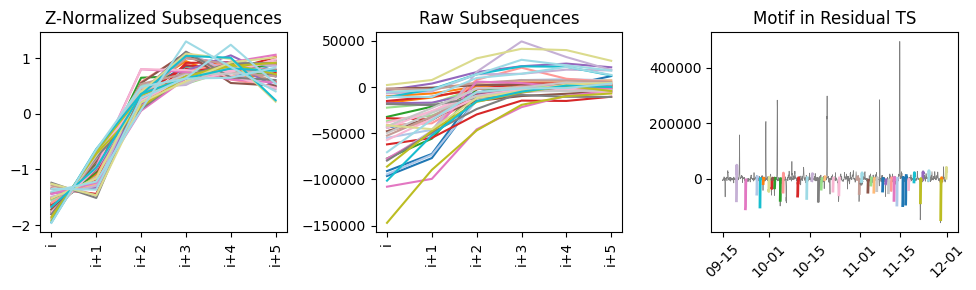

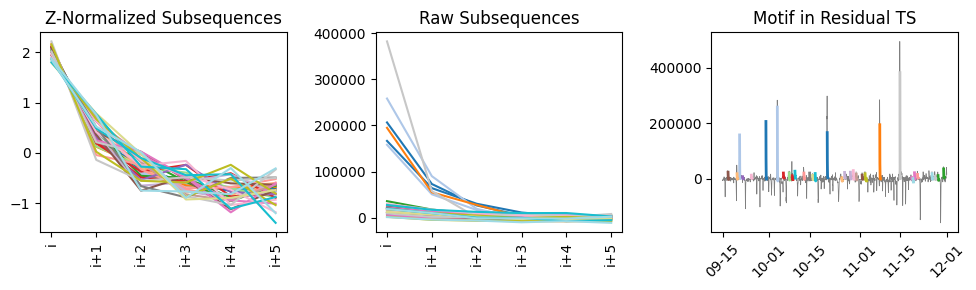

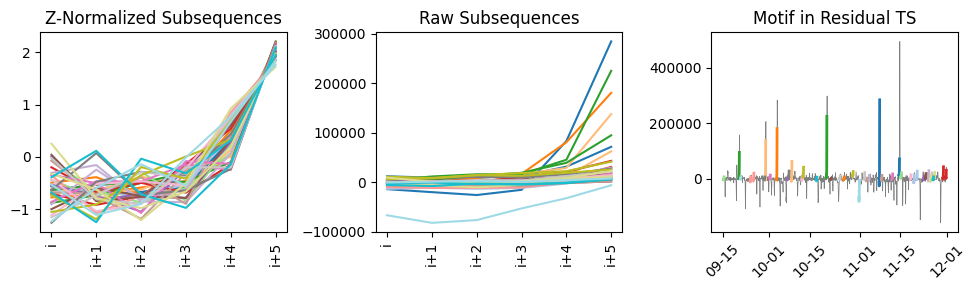

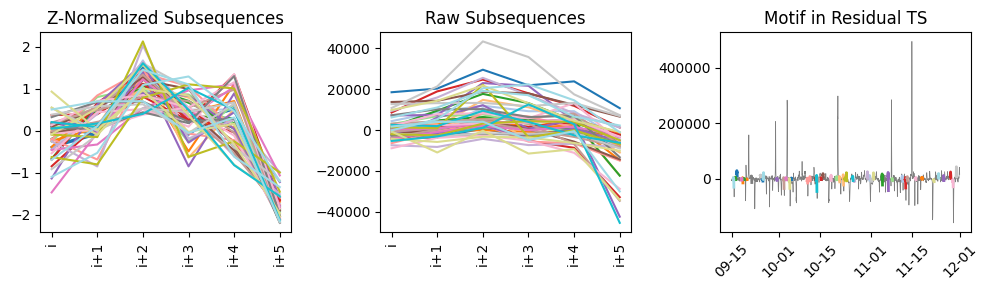

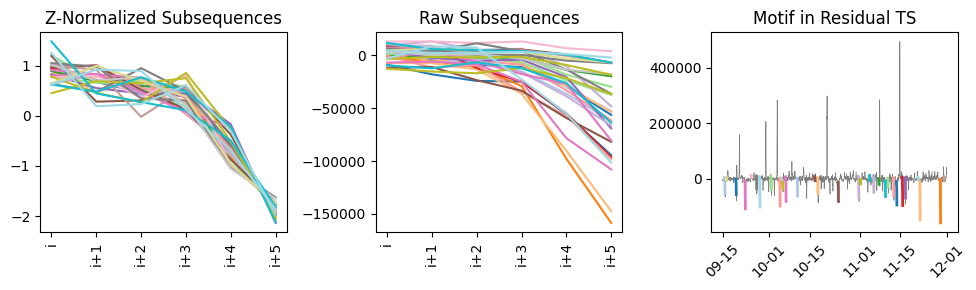

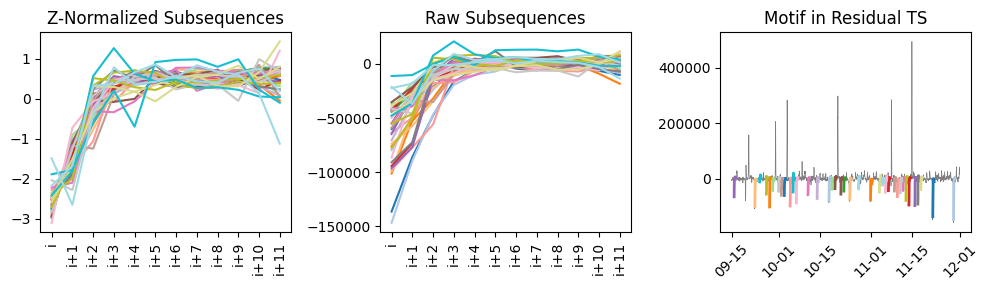

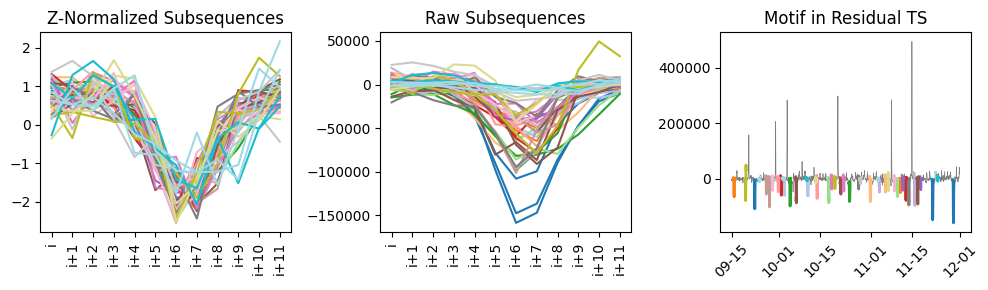

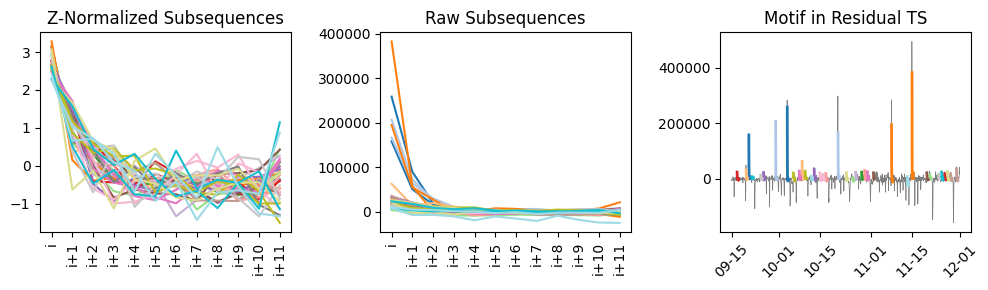

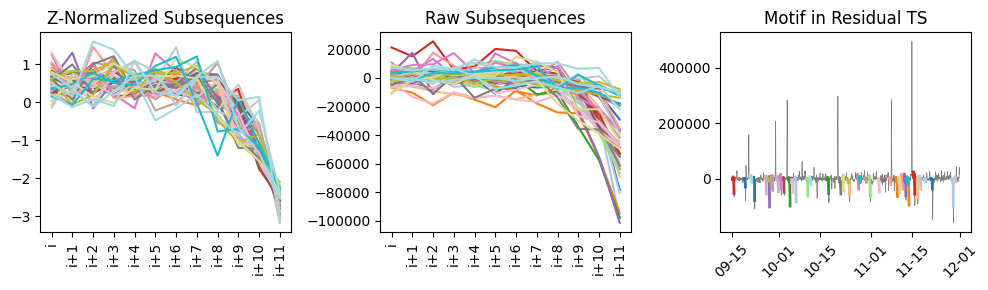

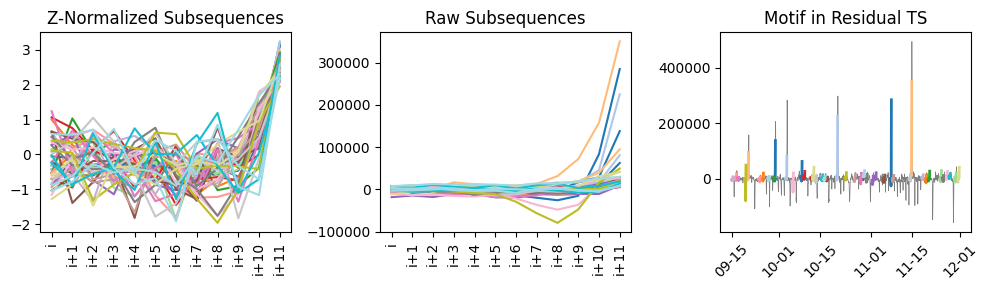

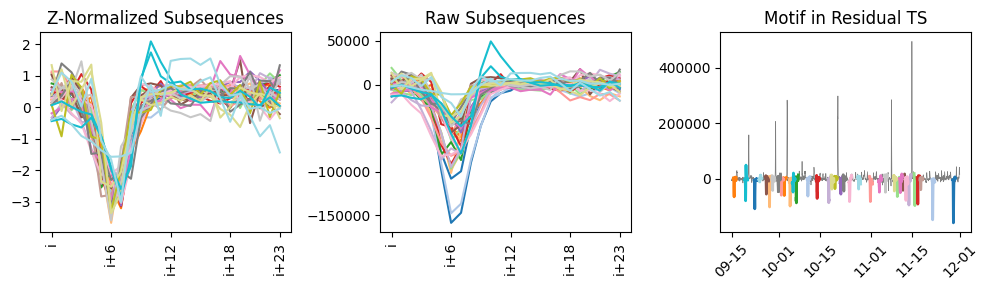

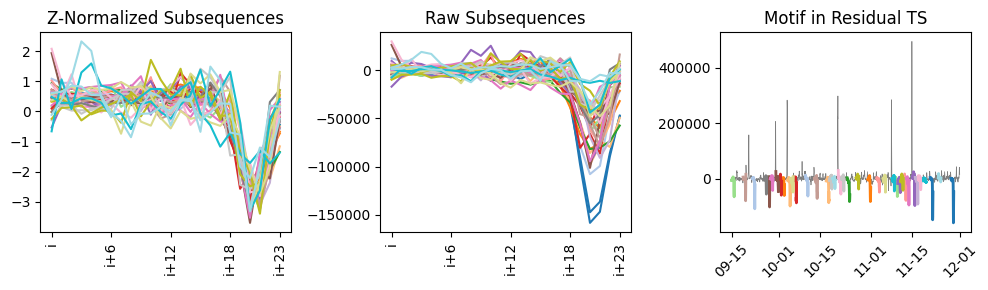

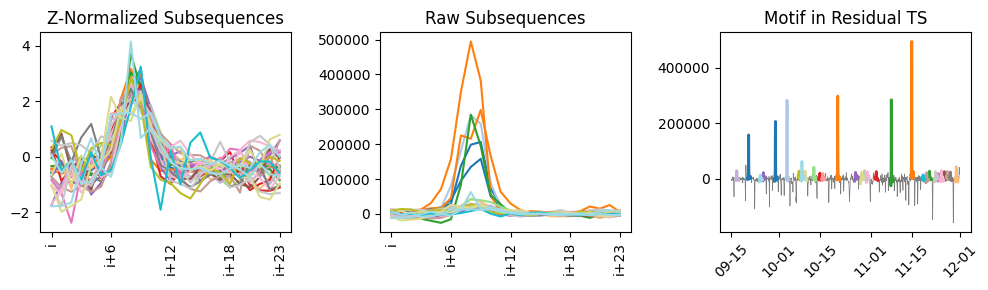

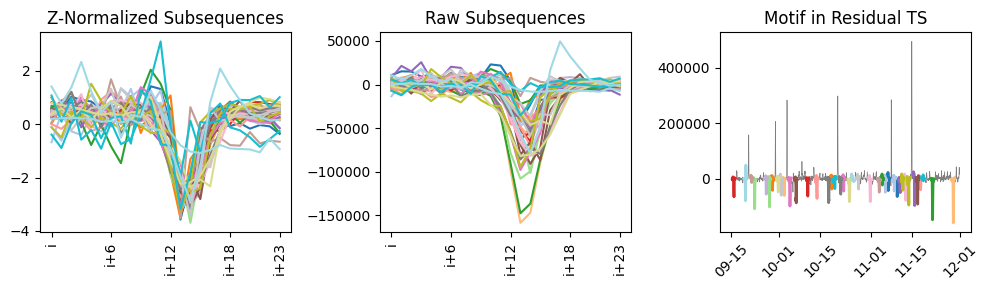

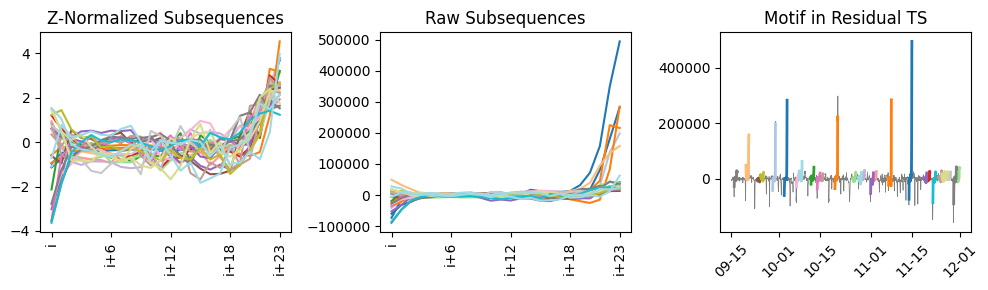

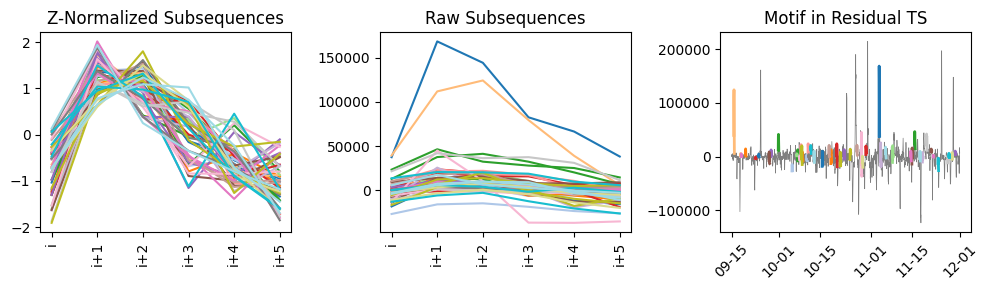

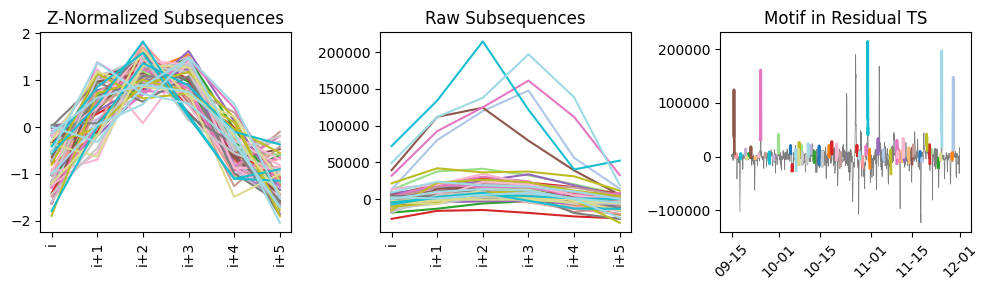

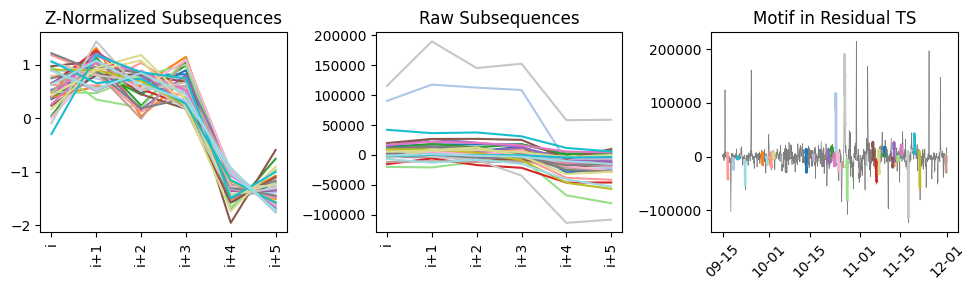

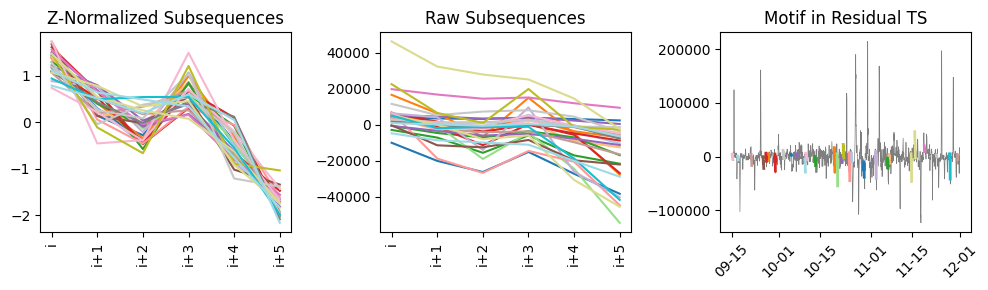

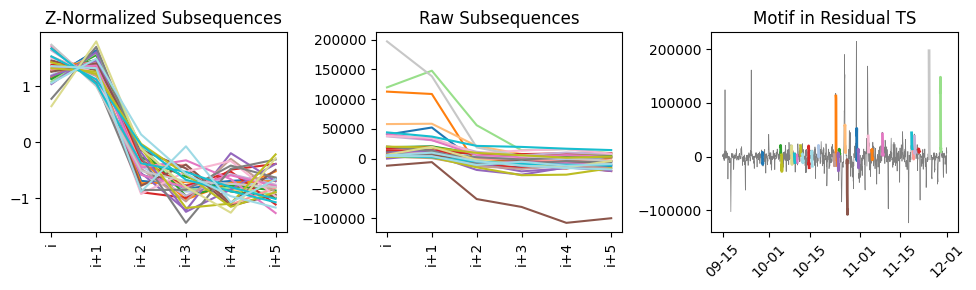

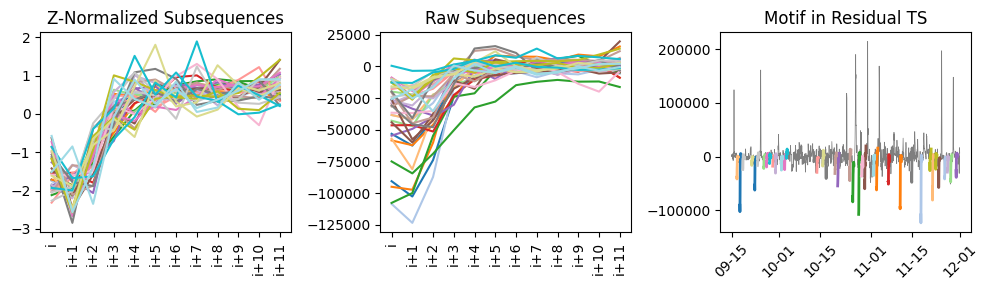

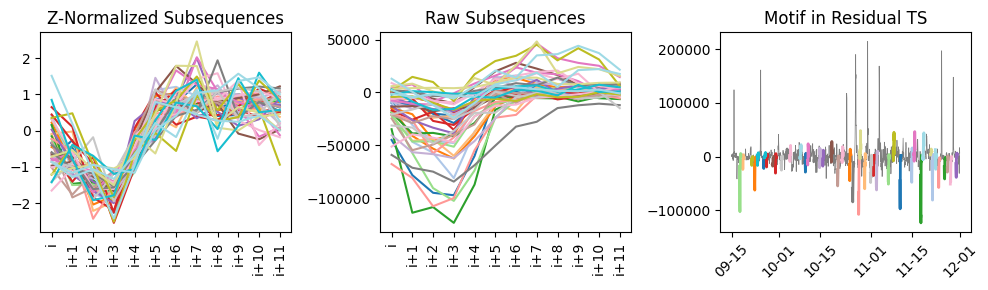

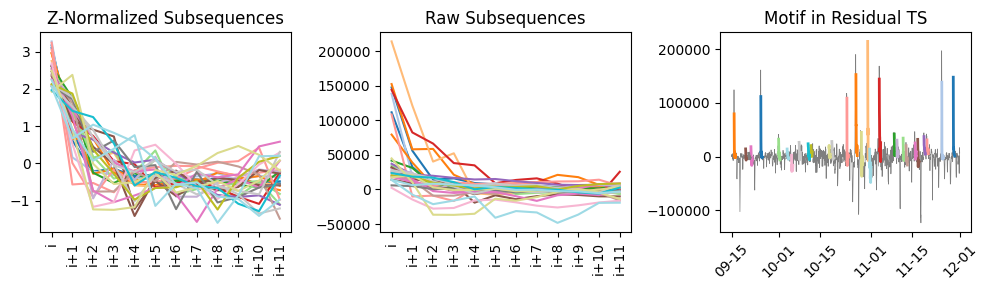

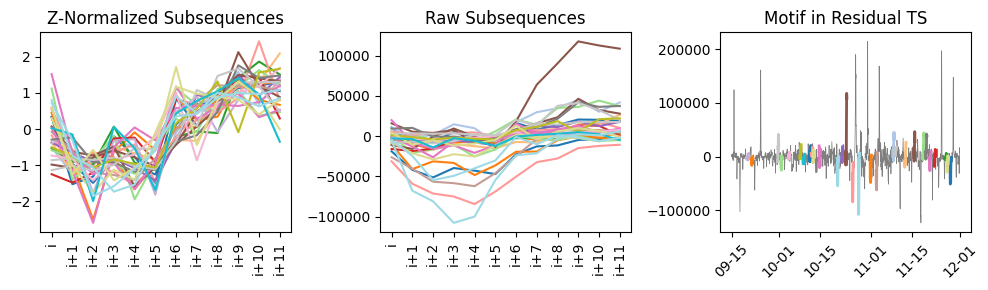

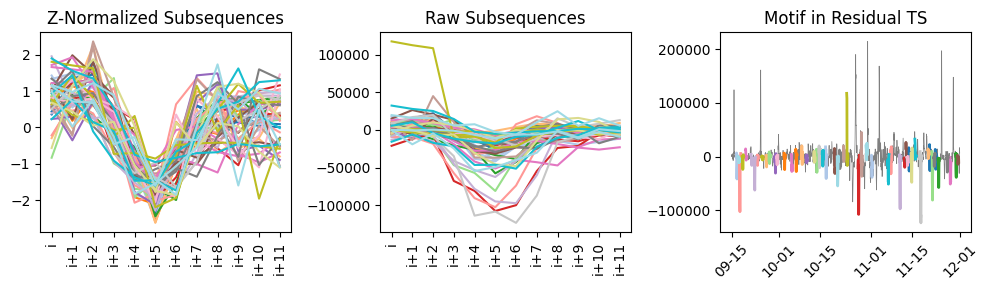

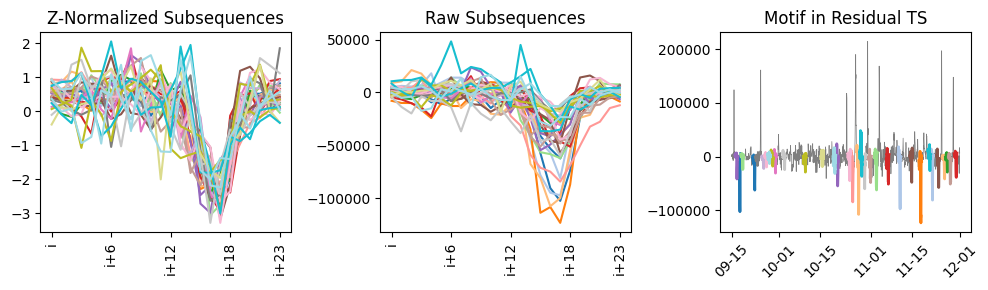

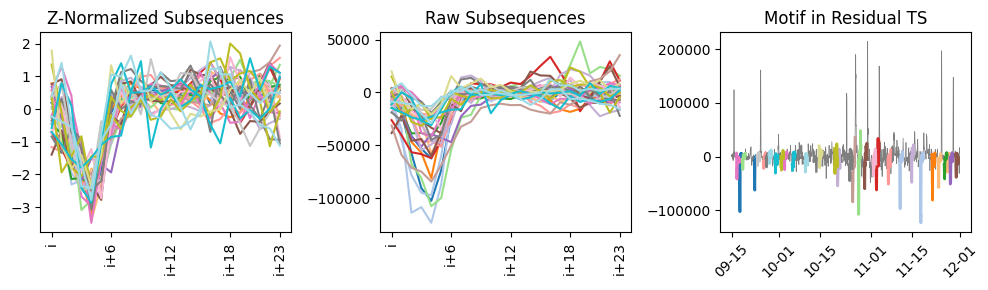

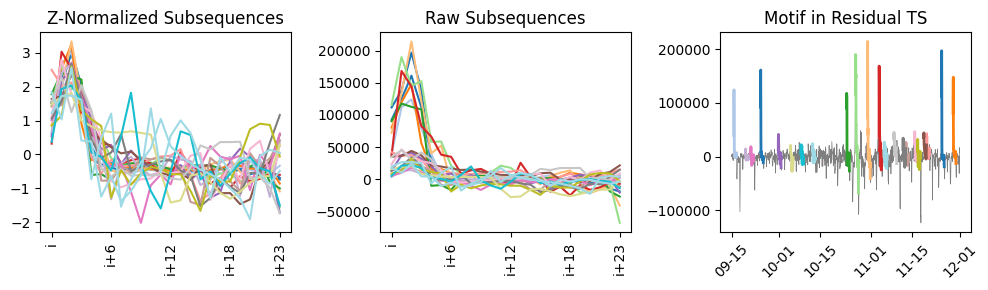

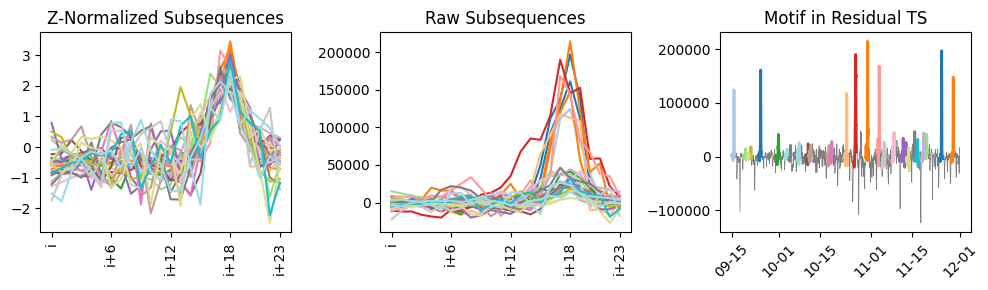

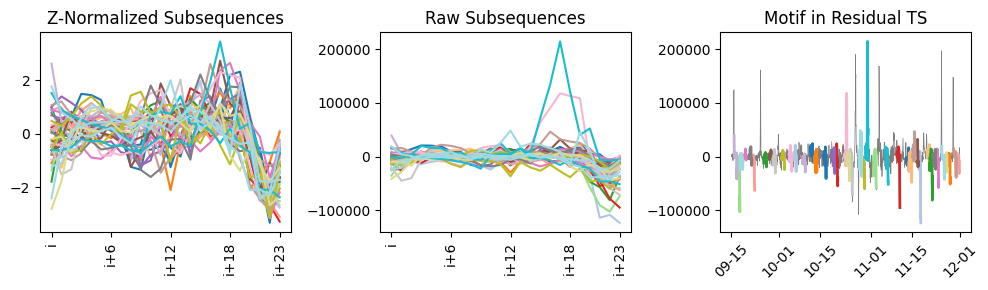

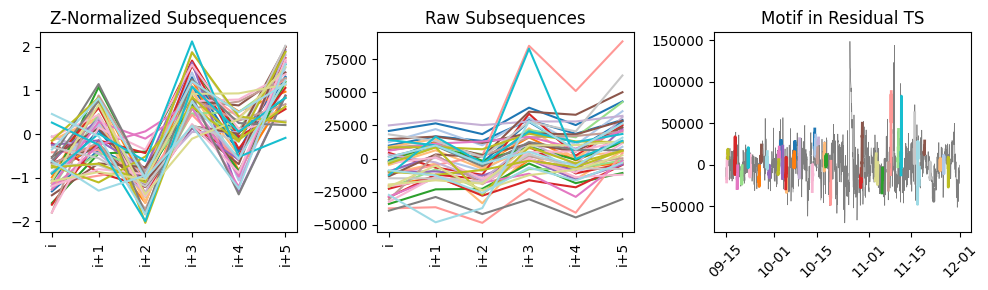

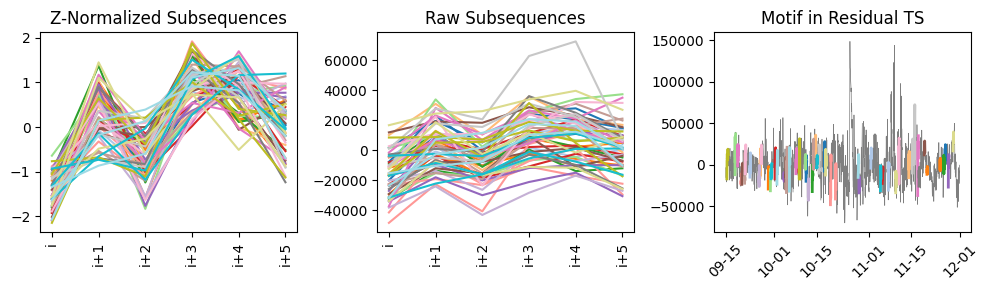

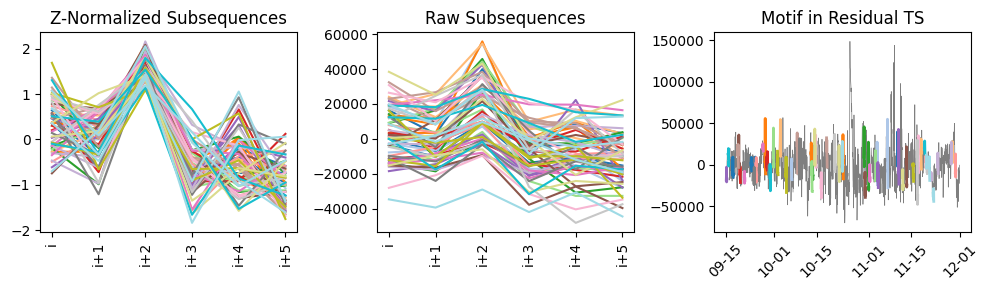

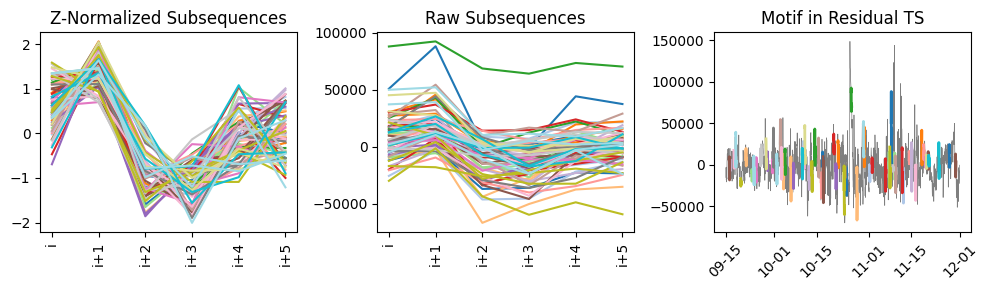

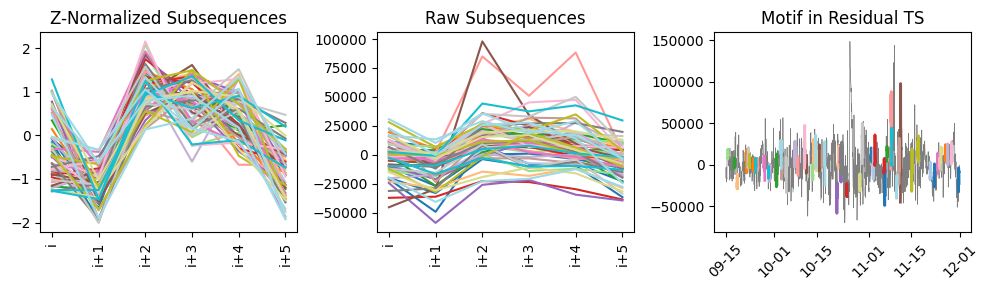

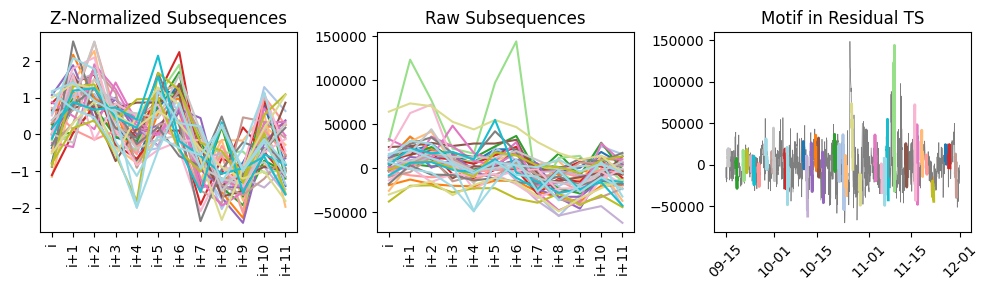

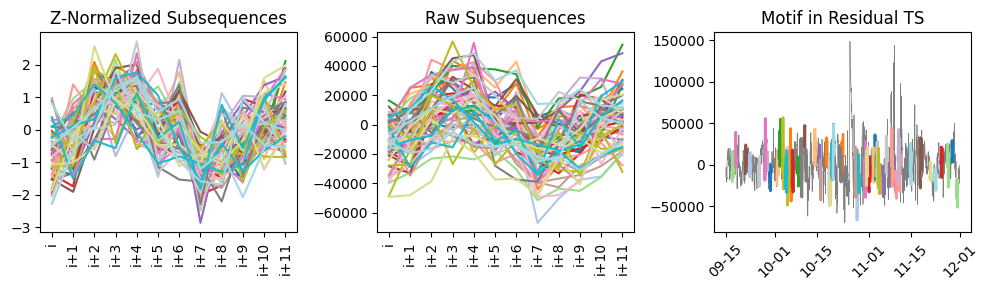

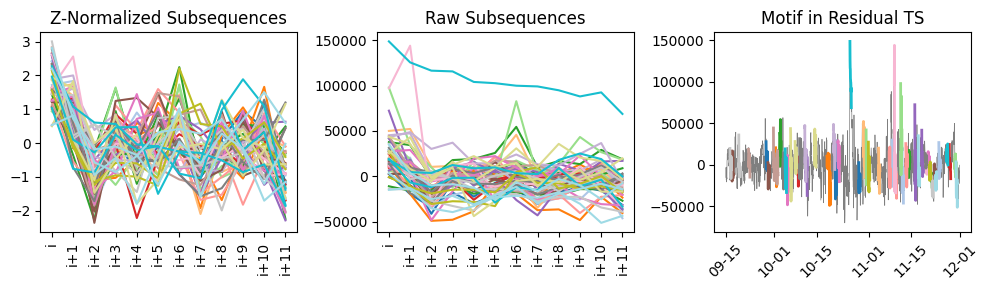

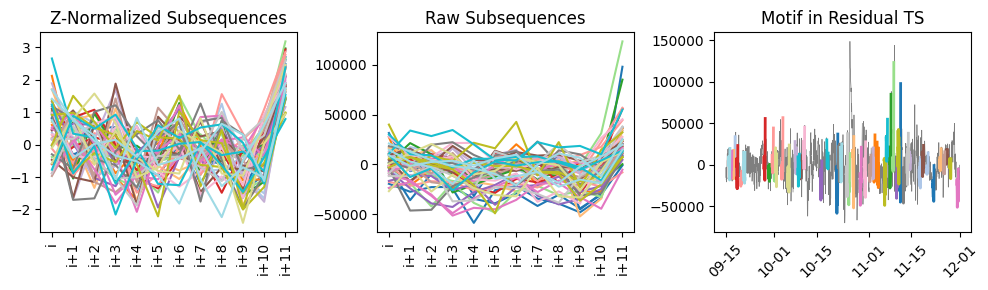

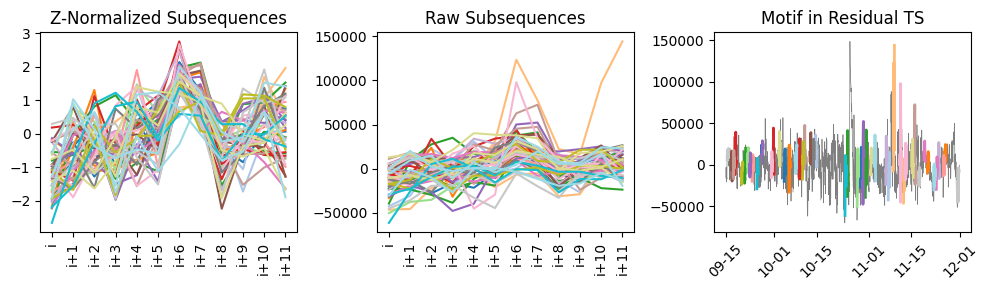

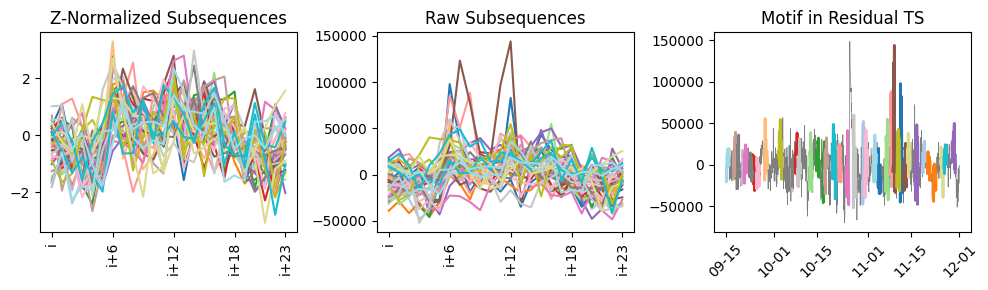

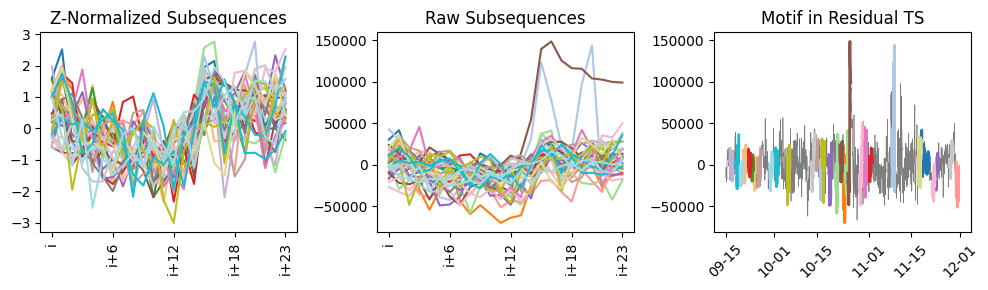

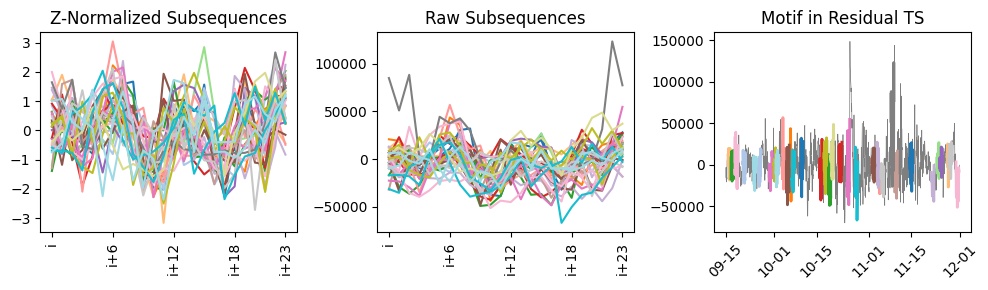

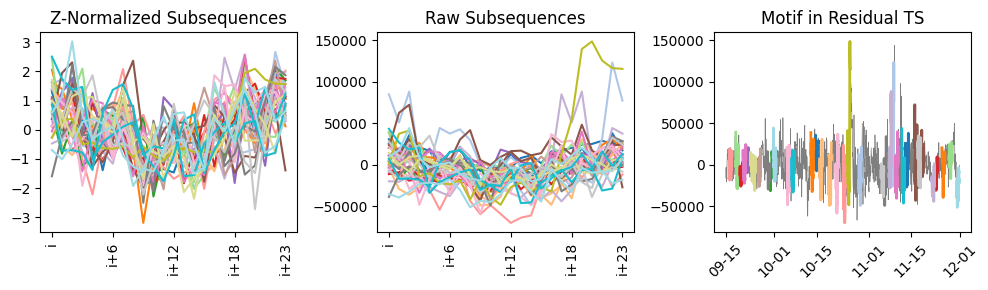

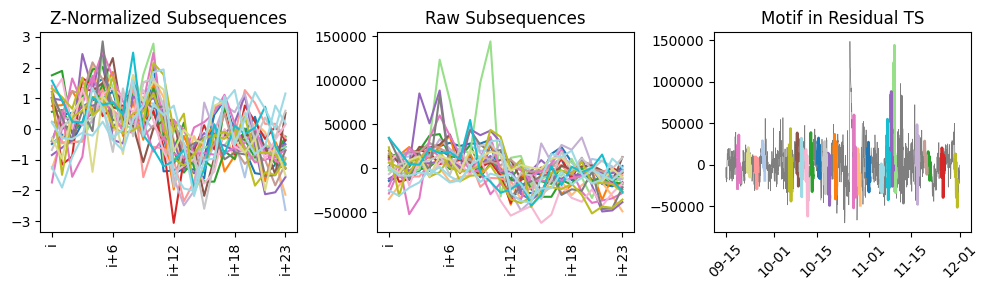

In [12]:
# plot top motif
for i, df in top_resids.groupby(by=["id", "feature"]):
    print("########## taz_name:{} #########".format(taz_id_name[i[0]]))
    mp_stats_table = pd.read_csv(
        results_path
        + "/table_motifs_normalize={}_min_neighbors={}_max_distance={}_cutoff={}_max_matches={}_max_motifs={}_{}.csv".format(
            normalize,
            min_neighbors,
            max_distance,
            cutoff,
            max_matches,
            max_motifs,
            i[0],
        )
    )
    mp_stats_table = mp_stats_table[mp_stats_table["p-value"] < 0.001]
    save_path = results_path + "/" + taz_id_name[i[0]]
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    subsequence_lengths = mp_stats_table["m"].unique()
    ts = pd.DataFrame(df["residuals"].values, index=df["index"])
    ts.index = pd.to_datetime(ts.index)
    for m in subsequence_lengths:
        print("Motif length: ", m)
        top_motifs = mp_stats_table[mp_stats_table["m"] == m]
        top_motifs = top_motifs.sort_values(by="Score Unified", ascending=False).head(5)
        for top_motif in top_motifs.to_dict(orient="records"):
            m = top_motif["m"]
            dimensions = [top_motif["Features"]]
            features = sorted([int(dimension) for dimension in dimensions])
            indices = top_motif["Indices"].replace("[", "").replace("]", "").split(",")
            indices = [int(i) for i in indices]
            motif_name = str(i[0]) + "_" + str(i[1]) + "_" + str(top_motif["ID"])
            plot_motif([ts], features, m, indices, motif_name, save_path)

# Daily TAZ granularity

In [13]:
# read csv
daily_data = pd.read_csv(
    "../data/populationdensity/daily_taz.csv",
    parse_dates=["one_time"],
    date_format="%Y-%m-%d",
    index_col=0,
)
# taz_id to taz_name dict
taz_id_name = {}
for taz_id in daily_data["taz_id"].unique():
    taz_name = daily_data[daily_data["taz_id"] == taz_id]["taz_name"].values[0]
    taz_id_name[taz_id] = taz_name

daily_data = daily_data[daily_data["taz_name"] != "Beato (Picheleira)"]
daily_data = daily_data[daily_data["taz_name"] != "Alcântara (Ribeirinha - Belém)"]
daily_data.head()

taz_id                       taz_name   one_time  sum_terminals  \
0       1     Belém (Ribeirinha - Belém) 2021-11-30       451966.0   
1      74      Santa Maria Maior (Baixa) 2021-11-30      3496997.0   
2      11          Ajuda (Ajuda | Oeste) 2021-11-30       187456.0   
3       2             Belém (Alto Duque) 2021-11-30      2003644.0   
4       8  Alcântara (Santo Amaro | Sul) 2021-11-30      1337005.0   

   sum_roaming_terminals  sum_terminals_with_active_data  \
0                28595.0                        433297.0   
1               448048.0                       3373682.0   
2                 2968.0                        181110.0   
3                18880.0                       1934676.0   
4                37381.0                       1255329.0   

   sum_roaming_terminals_with_active_data  sum_phonecalls  \
0                                 28420.0         16088.0   
1                                443026.0        101232.0   
2                                  2946.0          4871.0   
3                                 18754.0         52044.0   
4                                 36914.0         68161.0   

   sum_ended_phonecalls  avg_upstream_bandwidth  avg_downstream_bandwidth  \
0                3305.0             4853.284429              34185.103587   
1               26173.0            28874.841672              60980.068857   
2                1638.0             8833.336655              38008.021073   
3               24849.0             7428.568222              36438.320410   
4               11017.0             7111.558636              67180.857398   

   max_upstream_bandwidth  max_downstream_bandwidth  sum_terminals_sharing  \
0              56530416.0              4.827092e+08           0.000000e+00   
1             716870016.0              9.756566e+08           1.617781e-32   
2              56506204.0              1.839415e+08           0.000000e+00   
3             174233056.0              9.665061e+08           3.652603e-12   
4             129730224.0              1.080369e+09           4.030063e-10   

                                             wkt_taz  
0  POLYGON ((-9.196398200000004 38.69643299999995...  
1  POLYGON ((-9.1427544 38.71304069999996, -9.142...  
2  POLYGON ((-9.207034937118626 38.7136652379679,...  
3  POLYGON ((-9.216139788735672 38.71766017794581...  
4  POLYGON ((-9.178733600000001 38.70648729999996...

In [14]:
features = ["sum_terminals"]
stats_table = pd.DataFrame()
daily_taz_resids = {}
# for each taz_id
for taz_id in daily_data["taz_id"].unique():
    # get the data for that taz_id
    taz_data = daily_data[daily_data["taz_id"] == taz_id]
    taz_data = taz_data.drop(columns=["taz_name"])
    taz_data["datetime"] = pd.to_datetime(taz_data["one_time"])
    taz_data = taz_data.drop(columns=["one_time", "taz_id", "wkt_taz"])
    taz_data.set_index("datetime", inplace=True)
    for data_feature in features:
        time_serie = taz_data[[data_feature]].asfreq("d")
        if np.all(time_serie == 0):
            continue
        period = 7
        res = STL(np.squeeze(time_serie), period=period).fit()
        daily_taz_resids[str(taz_id) + "_" + data_feature] = res.resid

        var_resid = np.var(res.resid)
        var_observed = np.var(res.observed)
        trend_strength = max(0, 1 - (var_resid / np.var(res.trend + res.resid)))
        noise_strength = var_resid / var_observed

        seasonal_individial_strengths = {}
        seasonal_individial_strengths["F_" + str(period)] = max(
            0, 1 - (var_resid / np.var(res.seasonal + res.resid))
        )
        seasonal_strength = max(0, 1 - (var_resid / np.var(res.seasonal + res.resid)))

        stats_df = {
            "id": taz_id,
            "Name": taz_id_name[taz_id],
            "Feature": data_feature,
            "F_T": round(trend_strength, 3),
            "F_S": round(seasonal_strength, 3),
            "F_R": round(noise_strength, 3),
        }

        stats_df["F_S"] = round(seasonal_individial_strengths["F_" + str(period)], 3)

        stats_table = pd.concat(
            [stats_table, pd.DataFrame(stats_df, index=[0])], ignore_index=True
        )

# save the table
results_path = "../results/populationdensity/daily_taz"
# create folders in results path
if not os.path.exists(results_path):
    os.makedirs(results_path + "/mp")

pd.DataFrame(daily_taz_resids).to_csv(results_path + "/resids.csv", index=True)
stats_table = stats_table.sort_values(by=["F_R"], ascending=False)
stats_table.to_csv(results_path + "/decomposition_summary.csv", index=False)
stats_table.head()

id                                           Name        Feature    F_T  \
77  37  São Domingos de Benfica (Estrada Luz | Oeste)  sum_terminals  0.273   
93  89                             Lumiar (Aeroporto)  sum_terminals  0.365   
59  38                       Carnide (Avenidas Novas)  sum_terminals  0.511   
44  41                      Lumiar (Telheiras | Este)  sum_terminals  0.268   
0    1                     Belém (Ribeirinha - Belém)  sum_terminals  0.545   

      F_S    F_R  
77  0.418  0.479  
93  0.475  0.403  
59  0.304  0.402  
44  0.535  0.392  
0   0.287  0.386

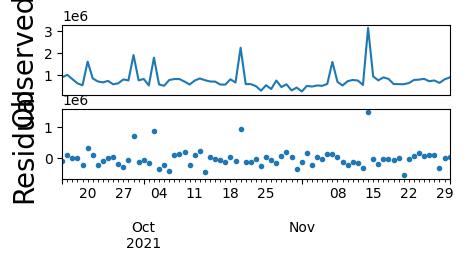

In [15]:
# plot the data and residuals of top 3 taz_ids
top_daily_taz_ids = stats_table["id"].head(1).values
# create dataframe with taz_id and resids
top_daily_taz_resids = pd.DataFrame()
for taz_id in top_daily_taz_ids:
    for data_feature in features:
        # add to dataframe, id, data feature and daoly
        observed = (
            daily_data[daily_data["taz_id"] == taz_id][[data_feature, "one_time"]]
            .sort_values(by="one_time")
            .set_index("one_time")
        )
        index = observed.index.values
        row = {
            "id": taz_id,
            "feature": data_feature,
            "index": index,
            "observed": observed.T.values[0],
            "residuals": daily_taz_resids[str(taz_id) + "_" + data_feature],
        }
        top_daily_taz_resids = pd.concat(
            [top_daily_taz_resids, pd.DataFrame(row)], ignore_index=True
        )


# for (id, feature) get dataframe and plot observed and residuals
for i, df in top_daily_taz_resids.groupby(by=["id", "feature"]):
    # plot observed and residuals
    fig, axes = plt.subplots(figsize=(5, 2), ncols=1, nrows=2, sharex=True)
    observed = pd.DataFrame(df["observed"].values, index=df["index"])
    resid = pd.DataFrame(df["residuals"].values, index=df["index"])
    observed.plot(ax=axes[0], legend=False, label="", xlabel="", ylabel="Observed")
    resid.plot(ax=axes[1], style=".", legend=False, xlabel="", ylabel="Residual")
    axes[0].axes.get_xaxis().set_visible(False)
    plt.show()

In [16]:
# motif discovery
import stumpy
from stumpy import config

config.STUMPY_EXCL_ZONE_DENOM = 2  # r = np.ceil(m/2)
top_k_mp = 1
include = None
normalize = True
subsequence_lengths = [6, 12, 24]

resids = pd.read_csv(results_path + "/resids.csv", index_col=0)

for m in subsequence_lengths:
    for i, df in top_daily_taz_resids.groupby(by=["id", "feature"]):
        X = np.squeeze(df["residuals"].values)
        out = stumpy.stump(X, m, normalize=normalize)
        np.save(
            results_path
            + "/mp/daily_taz_normalize={}_topkmp={}_m={}_{}_{}.npy".format(
                normalize, top_k_mp, m, i[0], i[1]
            ),
            out,
            allow_pickle=True,
        )

In [17]:
k_distances = None
min_neighbors = 1
cutoff = np.inf
max_matches = 99999
max_distance = None
max_motifs = 99999

for i, df in top_daily_taz_resids.groupby(by=["id", "feature"]):
    print(i[0], taz_id_name[i[0]])
    mp_stats_table = pd.DataFrame()
    for m in subsequence_lengths:
        X = np.squeeze(df["residuals"].values)
        mp = np.load(
            results_path
            + "/mp/daily_taz_normalize={}_topkmp={}_m={}_{}_{}.npy".format(
                normalize, top_k_mp, m, i[0], i[1]
            ),
            allow_pickle=True,
        )
        motif_distances, motif_indices = stumpy.motifs(
            X,
            mp[:, 0],
            max_distance=max_distance,
            max_matches=max_matches,
            cutoff=cutoff,
            min_neighbors=min_neighbors,
            max_motifs=max_motifs,
            normalize=normalize,
        )
        if len(motif_indices[0]) == 0:
            continue
        print("m:{}, #Motifs:{}".format(m, len(motif_indices)))
        # to work with table_summary_motifs which expects multidimensional motifs
        motif_subspaces = [np.array([0])] * len(motif_indices)
        X = np.array([X])
        table = table_summary_motifs(
            motif_indices,
            motif_distances,
            motif_subspaces,
            X,
            k_distances,
            m,
            normalize,
            max_distance,
        )
        print("Sig ", np.sum(table["p-value"] < 0.001))
        # hochberg procedure
        p_values = table["p-value"].to_numpy()
        critical_value = NullModel.hochberg_critical_value(p_values, 0.05)
        sig = (
            table["p-value"] < critical_value
            if critical_value != 0
            else table["p-value"] <= critical_value
        )
        table["Sig_Hochber"] = sig

        print(
            "Sig after Hochberg: {}, critical value: {}".format(
                np.sum(sig), critical_value
            )
        )
        mp_stats_table = (
            table
            if mp_stats_table.empty
            else pd.concat([mp_stats_table, table], ignore_index=True)
        )
    mp_stats_table.to_csv(
        results_path
        + "/table_motifs_normalize={}_min_neighbors={}_max_distance={}_cutoff={}_max_matches={}_max_motifs={}_{}.csv".format(
            normalize,
            min_neighbors,
            max_distance,
            cutoff,
            max_matches,
            max_motifs,
            i[0],
        ),
        index=False,
    )

37 São Domingos de Benfica (Estrada Luz | Oeste)
m:6, #Motifs:6
Sig  3
Sig after Hochberg: 3, critical value: 0.004980119364121521
m:12, #Motifs:4
Sig  4
Sig after Hochberg: 3, critical value: 0.00035400170665232064
m:24, #Motifs:1
Sig  1
Sig after Hochberg: 0, critical value: 6.999668872160513e-10


In [18]:
# get top 3 most significant for each motif length
for i, df in top_daily_taz_resids.groupby(by=["id", "feature"]):
    print("########## taz_name:{} #########".format(taz_id_name[i[0]]))
    mp_stats_table = pd.read_csv(
        results_path
        + "/table_motifs_normalize={}_min_neighbors={}_max_distance={}_cutoff={}_max_matches={}_max_motifs={}_{}.csv".format(
            normalize,
            min_neighbors,
            max_distance,
            cutoff,
            max_matches,
            max_motifs,
            i[0],
        )
    )
    # excluded p-value > 0.001
    # mp_stats_table = mp_stats_table[mp_stats_table["p-value"] < 0.001]
    subsequence_lengths = mp_stats_table["m"].unique()
    for m in subsequence_lengths:
        print("########## m:{} #########".format(m))
        top_motifs = mp_stats_table[mp_stats_table["m"] == m]
        top_motifs = top_motifs.sort_values(by="Score Unified", ascending=False).head(5)
        top_motifs = top_motifs[
            [
                "ID",
                "#Matches",
                "CE",
                "Score Unified",
                "max(dists)",
                "min(dists)",
                "med(dists)",
                "p-value",
                "Explained Var(%)",
            ]
        ]
        top_motifs["p-value"] = top_motifs["p-value"].apply(lambda x: f"{x:.2e}")
        print(top_motifs.to_latex(index=False, float_format="%.3f"))
        print("\n")

########## taz_name:São Domingos de Benfica (Estrada Luz | Oeste) #########
########## m:6 #########
\begin{tabular}{rrrrrrrlr}
\toprule
ID & #Matches & CE & Score Unified & max(dists) & min(dists) & med(dists) & p-value & Explained Var(%) \\
\midrule
1 & 3 & 0.594 & 0.415 & 0.911 & 0.368 & 0.692 & 1.40e-07 & 48.630 \\
2 & 1 & 0.424 & 0.380 & 0.504 & 0.504 & 0.504 & 2.57e-01 & 9.860 \\
0 & 3 & 0.525 & 0.298 & 1.291 & 0.350 & 1.068 & 1.59e-06 & 23.960 \\
4 & 2 & 0.578 & 0.292 & 1.346 & 1.027 & 1.187 & 2.22e-06 & 27.520 \\
3 & 2 & 0.486 & 0.283 & 1.209 & 1.011 & 1.110 & 4.98e-03 & 20.800 \\
\bottomrule
\end{tabular}



########## m:12 #########
\begin{tabular}{rrrrrrrlr}
\toprule
ID & #Matches & CE & Score Unified & max(dists) & min(dists) & med(dists) & p-value & Explained Var(%) \\
\midrule
0 & 1 & 0.394 & 0.384 & 1.175 & 1.175 & 1.175 & 3.54e-04 & 33.610 \\
1 & 2 & 0.379 & 0.330 & 1.833 & 1.513 & 1.673 & 3.33e-08 & 52.790 \\
2 & 2 & 0.419 & 0.313 & 2.034 & 1.977 & 2.006 & 5.12e-10 & 5

########## taz_name:São Domingos de Benfica (Estrada Luz | Oeste) #########
Motif length:  6


/home/miguel/miniconda3/envs/motifsinresidualenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3613: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


Motif length:  12


/home/miguel/miniconda3/envs/motifsinresidualenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3613: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


Motif length:  24


/home/miguel/miniconda3/envs/motifsinresidualenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3613: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


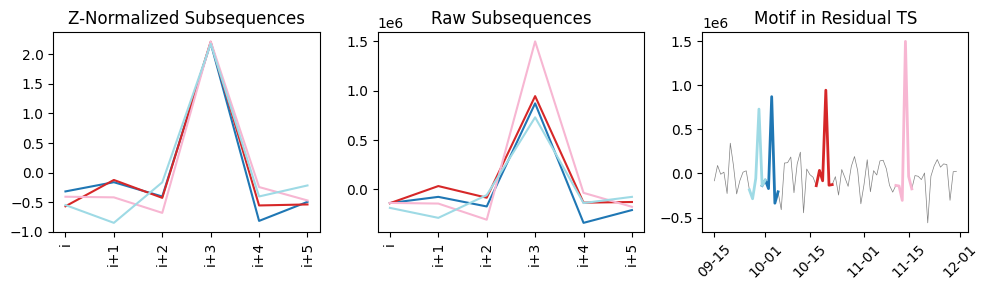

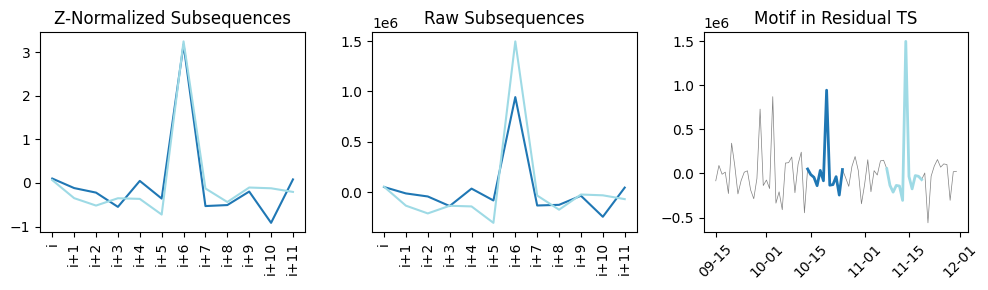

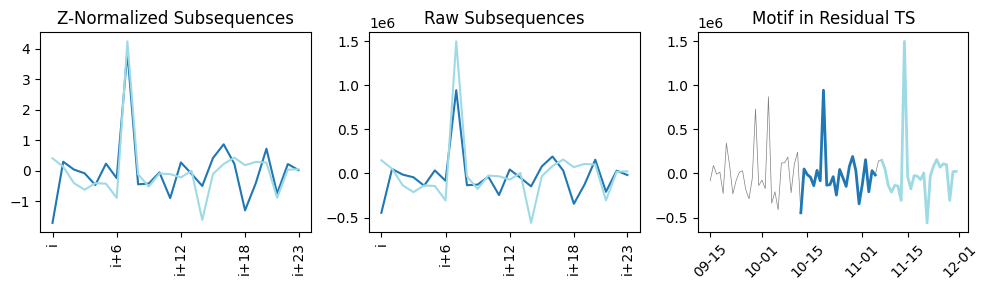

In [19]:
# plot top motif
for i, df in top_daily_taz_resids.groupby(by=["id", "feature"]):
    print("########## taz_name:{} #########".format(taz_id_name[i[0]]))
    mp_stats_table = pd.read_csv(
        results_path
        + "/table_motifs_normalize={}_min_neighbors={}_max_distance={}_cutoff={}_max_matches={}_max_motifs={}_{}.csv".format(
            normalize,
            min_neighbors,
            max_distance,
            cutoff,
            max_matches,
            max_motifs,
            i[0],
        )
    )
    # mp_stats_table = mp_stats_table[mp_stats_table["p-value"] < 0.001]
    save_path = results_path + "/" + taz_id_name[i[0]]
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    subsequence_lengths = mp_stats_table["m"].unique()
    ts = pd.DataFrame(df["residuals"].values, index=df["index"])
    ts.index = pd.to_datetime(ts.index)
    for m in subsequence_lengths:
        print("Motif length: ", m)
        top_motifs = mp_stats_table[mp_stats_table["m"] == m]
        top_motifs = top_motifs.sort_values(by="Score Unified", ascending=False).head(1)
        for top_motif in top_motifs.to_dict(orient="records"):
            m = top_motif["m"]
            dimensions = [top_motif["Features"]]
            features = sorted([int(dimension) for dimension in dimensions])
            indices = top_motif["Indices"].replace("[", "").replace("]", "").split(",")
            indices = [int(i) for i in indices]
            motif_name = str(i[0]) + "_" + str(i[1]) + "_" + str(top_motif["ID"])
            plot_motif([ts], features, m, indices, motif_name, save_path)

# Hourly Township Granularity

In [20]:
hourly_township_data = pd.read_csv(
    "../data/populationdensity/hourly_township.csv",
    parse_dates=["one_time"],
    date_format="%Y-%m-%d %H:%M:%S",
    index_col=0,
)
# remove santa clara
hourly_township_data = hourly_township_data[
    hourly_township_data["township_name"] != "Santa Clara"
]
hourly_township_data.head()

dicofre_code    township_name            one_time  sum_terminals  \
0        110663  Penha de França 2021-11-29 13:00:00       158355.0   
1        110660          Estrela 2021-11-29 13:00:00       126795.0   
2        110661     Misericórdia 2021-11-29 13:00:00       130089.0   
3        110610        Campolide 2021-11-29 13:00:00       141620.0   
4        110654         Alvalade 2021-11-29 13:00:00       552447.0   

   sum_roaming_terminals  sum_terminals_with_active_data  \
0                 3274.0                        150382.0   
1                 5971.0                        119324.0   
2                11769.0                        123826.0   
3                 2863.0                        131858.0   
4                 8924.0                        522013.0   

   sum_roaming_terminals_with_active_data  sum_phonecalls  \
0                                  3208.0          5579.0   
1                                  5903.0          6419.0   
2                                 11580.0          5293.0   
3                                  2824.0          6629.0   
4                                  8800.0         22186.0   

   sum_ended_phonecalls  avg_upstream_bandwidth  avg_downstream_bandwidth  \
0                1838.0            16385.683844             146081.324196   
1                1155.0            16553.045512              91474.076898   
2                1368.0            48063.316006              47523.270522   
3                1506.0             4798.054128              34495.467216   
4                6200.0            12529.229719              56706.753777   

   min_avg_downstream_bandwidth  min_avg_upstream_bandwidth  \
0                          0.00                        0.00   
1                          0.00                        0.00   
2                         74.75                        2.98   
3                          0.00                        0.00   
4                          0.00                        0.00   

   max_upstream_bandwidth  max_downstream_bandwidth  sum_terminals_sharing  \
0             100624952.0              3.455197e+08           0.000000e+00   
1             104582392.0              3.770962e+09           0.000000e+00   
2             201988720.0              2.098639e+08           0.000000e+00   
3             205520528.0              4.913501e+08           6.747917e-15   
4             302661568.0              2.107258e+08           0.000000e+00   

                                        wkt_township  
0  POLYGON ((-9.12640197112175 38.7377428485445, ...  
1  POLYGON ((-9.16080983332722 38.7155471461725, ...  
2  POLYGON ((-9.14552445708381 38.7155620897881, ...  
3  POLYGON ((-9.16666516643514 38.7393905242751, ...  
4  POLYGON ((-9.12857219484697 38.763017767016, -...

In [21]:
features = ["sum_terminals"]
stats_table = pd.DataFrame()
hourly_township_resids = {}

for township_name in hourly_township_data["township_name"].unique():
    township_data = hourly_township_data[
        hourly_township_data["township_name"] == township_name
    ].copy()
    township_data["datetime"] = pd.to_datetime(township_data["one_time"])
    township_data = township_data.drop(
        columns=["one_time", "township_name", "wkt_township"]
    )
    township_data.set_index("datetime", inplace=True)
    for data_feature in features:
        time_serie = township_data[[data_feature]].asfreq("h")
        if np.all(time_serie == 0):
            continue
        res = MSTL(np.squeeze(time_serie), periods=[24, 24 * 7]).fit()
        hourly_township_resids[str(township_name) + "_" + data_feature] = res.resid

        var_resid = np.var(res.resid)
        var_observed = np.var(res.observed)
        trend_strength = max(0, 1 - (var_resid / np.var(res.trend + res.resid)))
        noise_strength = var_resid / var_observed

        seasonal_individial_strengths = {}
        for period in res.seasonal:
            seasonal_individial_strengths["F_" + str(period)] = max(
                0, 1 - (var_resid / np.var(res.seasonal[period] + res.resid))
            )
        seasonal_strength = max(
            0, 1 - (var_resid / np.var(res.seasonal.sum(axis=1) + res.resid))
        )

        stats_df = {
            "township_name": township_name,
            "Feature": data_feature,
            "F_T": round(trend_strength, 3),
            "F_S": round(seasonal_strength, 3),
            "F_R": round(noise_strength, 3),
        }

        # add individual seasonal strengths to stats_df, rounded with 3 decimals
        for period in seasonal_individial_strengths:
            stats_df[period] = round(seasonal_individial_strengths[period], 3)

        stats_table = pd.concat(
            [stats_table, pd.DataFrame(stats_df, index=[0])], ignore_index=True
        )


# save the table
results_path = "../results/populationdensity/hourly_township"
# create folders in results path
if not os.path.exists(results_path):
    os.makedirs(results_path + "/mp")


pd.DataFrame(hourly_township_resids).to_csv(results_path + "/resids.csv", index=True)
stats_table = stats_table.sort_values(by=["F_R"], ascending=False)
stats_table.to_csv(results_path + "/decomposition_summary.csv", index=False)
stats_table.head()

township_name        Feature    F_T    F_S    F_R  F_seasonal_24  \
17      São Vicente  sum_terminals  0.510  0.394  0.369          0.267   
12            Ajuda  sum_terminals  0.484  0.575  0.301          0.474   
11          Areeiro  sum_terminals  0.478  0.598  0.294          0.428   
0   Penha de França  sum_terminals  0.619  0.459  0.286          0.354   
1           Estrela  sum_terminals  0.492  0.653  0.256          0.454   

    F_seasonal_168  
17           0.226  
12           0.311  
11           0.421  
0            0.233  
1            0.510

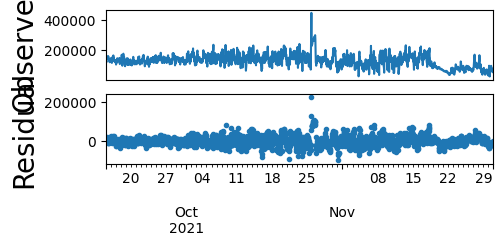

In [22]:
# plot the data and residuals of top 3 taz_ids
top_hourly_township_ids = stats_table["township_name"].head(1).values
# create dataframe with taz_id and resids
top_hourly_township_resids = pd.DataFrame()
for township_id in top_hourly_township_ids:
    for data_feature in features:
        # add to dataframe, id, data feature and daoly
        observed = (
            hourly_township_data[hourly_township_data["township_name"] == township_id][
                [data_feature, "one_time"]
            ]
            .sort_values(by="one_time")
            .set_index("one_time")
        )
        index = observed.index.values
        row = {
            "id": township_id,
            "feature": data_feature,
            "index": index,
            "observed": observed.T.values[0],
            "residuals": hourly_township_resids[str(township_id) + "_" + data_feature],
        }
        top_hourly_township_resids = pd.concat(
            [top_hourly_township_resids, pd.DataFrame(row)], ignore_index=True
        )


for i, df in top_hourly_township_resids.groupby(by=["id", "feature"]):
    # plot observed and residuals
    fig, axes = plt.subplots(figsize=(5, 2), ncols=1, nrows=2, sharex=True)
    observed = pd.DataFrame(df["observed"].values, index=df["index"])
    resid = pd.DataFrame(df["residuals"].values, index=df["index"])
    observed.plot(ax=axes[0], legend=False, label="", xlabel="", ylabel="Observed")
    resid.plot(ax=axes[1], style=".", legend=False, xlabel="", ylabel="Residual")
    axes[0].axes.get_xaxis().set_visible(False)
    plt.show()

In [23]:
# motif discovery
import stumpy

config.STUMPY_EXCL_ZONE_DENOM = 2  # r = np.ceil(m/2)
top_k_mp = 1
include = None
normalize = True
subsequence_lengths = [12]

for m in subsequence_lengths:
    for i, df in top_hourly_township_resids.groupby(by=["id", "feature"]):
        X = np.squeeze(df["residuals"].values)
        out = stumpy.stump(X, m, normalize=normalize)
        np.save(
            results_path
            + "/mp/hourly_township_normalize={}_topkmp={}_m={}_{}_{}.npy".format(
                normalize, top_k_mp, m, i[0], i[1]
            ),
            out,
            allow_pickle=True,
        )

In [24]:
k_distances = None
min_neighbors = 2
cutoff = np.inf
max_matches = 99999
max_distance = None
max_motifs = 99999

for i, df in top_hourly_township_resids.groupby(by=["id", "feature"]):
    print(i[0])
    mp_stats_table = pd.DataFrame()
    for m in subsequence_lengths:
        X = np.squeeze(df["residuals"].values)
        mp = np.load(
            results_path
            + "/mp/hourly_township_normalize={}_topkmp={}_m={}_{}_{}.npy".format(
                normalize, top_k_mp, m, i[0], i[1]
            ),
            allow_pickle=True,
        )
        motif_distances, motif_indices = stumpy.motifs(
            X,
            mp[:, 0],
            max_distance=max_distance,
            max_matches=max_matches,
            cutoff=cutoff,
            min_neighbors=min_neighbors,
            max_motifs=max_motifs,
            normalize=normalize,
        )
        if len(motif_indices[0]) == 0:
            continue
        print("m:{}, #Motifs:{}".format(m, len(motif_indices)))
        # to work with table_summary_motifs which expects multidimensional motifs
        motif_subspaces = [np.array([0])] * len(motif_indices)
        X = np.array([X])
        table = table_summary_motifs(
            motif_indices,
            motif_distances,
            motif_subspaces,
            X,
            k_distances,
            m,
            normalize,
            max_distance,
        )
        print("Sig ", np.sum(table["p-value"] < 0.001))
        # hochberg procedure
        p_values = table["p-value"].to_numpy()
        critical_value = NullModel.hochberg_critical_value(p_values, 0.05)
        sig = (
            table["p-value"] < critical_value
            if critical_value != 0
            else table["p-value"] <= critical_value
        )
        table["Sig_Hochber"] = sig

        print(
            "Sig after Hochberg: {}, critical value: {}".format(
                np.sum(sig), critical_value
            )
        )
        mp_stats_table = (
            table
            if mp_stats_table.empty
            else pd.concat([mp_stats_table, table], ignore_index=True)
        )
    mp_stats_table.to_csv(
        results_path
        + "/table_motifs_normalize={}_min_neighbors={}_max_distance={}_cutoff={}_max_matches={}_max_motifs={}_{}.csv".format(
            normalize,
            min_neighbors,
            max_distance,
            cutoff,
            max_matches,
            max_motifs,
            i[0],
        ),
        index=False,
    )

São Vicente
m:12, #Motifs:16


Sig  16
Sig after Hochberg: 15, critical value: 2.386791533622633e-32


In [25]:
# get top 3 most significant for each motif length
for i, df in top_hourly_township_resids.groupby(by=["id", "feature"]):
    print("########## township_name:{} #########".format(i[0]))
    mp_stats_table = pd.read_csv(
        results_path
        + "/table_motifs_normalize={}_min_neighbors={}_max_distance={}_cutoff={}_max_matches={}_max_motifs={}_{}.csv".format(
            normalize,
            min_neighbors,
            max_distance,
            cutoff,
            max_matches,
            max_motifs,
            i[0],
        )
    )
    # excluded p-value > 0.001
    mp_stats_table = mp_stats_table[mp_stats_table["p-value"] < 0.001]
    subsequence_lengths = mp_stats_table["m"].unique()
    for m in subsequence_lengths:
        print("########## m:{} #########".format(m))
        top_motifs = mp_stats_table[mp_stats_table["m"] == m]
        top_motifs = top_motifs.sort_values(by="Score Unified", ascending=False).head(5)
        top_motifs = top_motifs[
            [
                "ID",
                "#Matches",
                "CE",
                "Score Unified",
                "max(dists)",
                "min(dists)",
                "med(dists)",
                "p-value",
                "Explained Var(%)",
            ]
        ]
        top_motifs["p-value"] = top_motifs["p-value"].apply(lambda x: f"{x:.2e}")
        print(top_motifs.to_latex(index=False, float_format="%.3f"))
        print("\n")

########## township_name:São Vicente #########
########## m:12 #########
\begin{tabular}{rrrrrrrlr}
\toprule
ID & #Matches & CE & Score Unified & max(dists) & min(dists) & med(dists) & p-value & Explained Var(%) \\
\midrule
14 & 44 & 0.501 & 0.246 & 3.428 & 1.995 & 3.102 & 8.07e-86 & 29.030 \\
12 & 45 & 0.471 & 0.237 & 3.480 & 1.682 & 3.138 & 9.32e-79 & 27.670 \\
11 & 43 & 0.489 & 0.234 & 3.219 & 1.497 & 2.985 & 7.76e-63 & 26.450 \\
8 & 55 & 0.353 & 0.203 & 3.253 & 1.202 & 3.000 & 6.30e-51 & 34.120 \\
9 & 48 & 0.345 & 0.197 & 3.108 & 1.320 & 2.828 & 4.95e-138 & 35.100 \\
\bottomrule
\end{tabular}





########## township_name:São Vicente #########
Motif length:  12


/home/miguel/miniconda3/envs/motifsinresidualenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3613: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


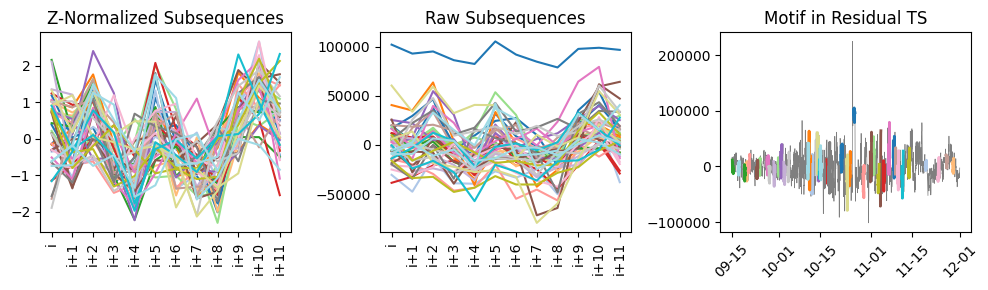

In [26]:
# plot top motif
for i, df in top_hourly_township_resids.groupby(by=["id", "feature"]):
    print("########## township_name:{} #########".format(i[0]))
    mp_stats_table = pd.read_csv(
        results_path
        + "/table_motifs_normalize={}_min_neighbors={}_max_distance={}_cutoff={}_max_matches={}_max_motifs={}_{}.csv".format(
            normalize,
            min_neighbors,
            max_distance,
            cutoff,
            max_matches,
            max_motifs,
            i[0],
        )
    )
    mp_stats_table = mp_stats_table[mp_stats_table["p-value"] < 0.001]
    save_path = results_path + "/" + i[0]
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    subsequence_lengths = mp_stats_table["m"].unique()
    ts = pd.DataFrame(df["residuals"].values, index=df["index"])
    ts.index = pd.to_datetime(ts.index)
    for m in subsequence_lengths:
        print("Motif length: ", m)
        top_motifs = mp_stats_table[mp_stats_table["m"] == m]
        top_motifs = top_motifs.sort_values(by="Score Unified", ascending=False).head(1)
        for top_motif in top_motifs.to_dict(orient="records"):
            m = top_motif["m"]
            dimensions = [top_motif["Features"]]
            features = sorted([int(dimension) for dimension in dimensions])
            indices = top_motif["Indices"].replace("[", "").replace("]", "").split(",")
            indices = [int(i) for i in indices]
            motif_name = str(i[0]) + "_" + str(i[1]) + "_" + str(top_motif["ID"])
            plot_motif([ts], features, m, indices, motif_name, save_path)